## Load Data

In [1]:
#Import initial packages and data.

import pandas as pd
import seaborn as sns
sns.set_context('notebook')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings as wrns
wrns.filterwarnings('ignore')
data = pd.read_csv('train.csv')
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SalePrice
0,20,RL,NaN,7000,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,GdWo,NaN,0,7,2009,WD,136500
1,20,RL,70.0,11767,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,Shed,900,6,2009,WD,120000
2,60,RL,75.0,9675,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2009,WD,253000
3,160,FV,24.0,2160,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2008,WD,170000
4,75,RM,65.0,8850,Pave,NaN,IR1,Bnk,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,7,2006,ConLw,144000


## Missing Data Handling 

In [2]:
#Seperate data by variable types.

Continuous = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
              '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF',
              'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']

Discrete = ['GarageYrBlt', 'YearRemod/Add', 'YearBuilt', 'BsmtFullBath','FullBath','HalfBath','BedroomAbvGr',
            'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','MoSold','YrSold']

Ordinal=['Utilities','LotShape','LandSlope','OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual',
         'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','Electrical','KitchenQual',
         'Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence']

Nominal = ['MSSubClass','MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1',
           'Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
           'MasVnrType','Foundation','Heating','CentralAir','GarageType','MiscFeature','SaleType']


In [3]:
#Define function to find missing values.

def num_missing(x):
  return sum(x.isnull())

In [4]:
#Find number of missing values for continuous variables.

print ('Missing values for continuous variables:')
missing_con = pd.DataFrame(data[Continuous].apply(num_missing, axis=0)[data[Continuous].apply(num_missing, axis=0)>0])
missing_con

Missing values for continuous variables:


,0
LotFrontage,157
MasVnrArea,4


In [5]:
#Find number of missing values for discrete variables.

print ('Missing values for discrete variables:')
missing_dis = pd.DataFrame(data[Discrete].apply(num_missing, axis=0)[data[Discrete].apply(num_missing, axis=0)>0])
missing_dis

Missing values for discrete variables:


,0
GarageYrBlt,36


In [6]:
#Find number of missing values for ordinal variables.

print ('Missing values for ordinal variables:')
missing_ord = pd.DataFrame(data[Ordinal].apply(num_missing, axis=0)[data[Ordinal].apply(num_missing, axis=0)>0])
missing_ord

Missing values for ordinal variables:


,0
BsmtQual,21
BsmtCond,21
BsmtExposure,22
BsmtFinType1,21
BsmtFinType2,21
FireplaceQu,386
GarageFinish,36
GarageQual,36
GarageCond,36
PoolQC,801


In [7]:
#Find number of missing values for nominal variables.

print ('Missing values for nominal variables:')
missing_nom = pd.DataFrame(data[Nominal].apply(num_missing, axis=0)[data[Nominal].apply(num_missing, axis=0)>0])
missing_nom

Missing values for nominal variables:


,0
Alley,749
MasVnrType,4
GarageType,36
MiscFeature,781


In [8]:
#Filter out rows where MasVnrArea data is missing arbitrarily. This calls into question the entire row.

data = data[data['MasVnrArea'] >= 0]

#Fill object type blanks with NA or 0 as appropriate. Doing one by one instead of loop to easily see all altered variables.
#GarageYrBlt left as is and will be dealt with at later stage.

data['LotFrontage'] = data['LotFrontage'].fillna(0)
data['Alley'] = data['Alley'].fillna('NA')
data['BsmtQual'] = data['BsmtQual'].fillna('NA')
data['BsmtCond'] = data['BsmtCond'].fillna('NA')
data['BsmtExposure'] = data['BsmtExposure'].fillna('NA')
data['BsmtFinType1'] = data['BsmtFinType1'].fillna('NA')
data['BsmtFinType2'] = data['BsmtFinType2'].fillna('NA')
data['FireplaceQu'] = data['FireplaceQu'].fillna('NA')
data['GarageType'] = data['GarageType'].fillna('NA')
data['GarageFinish'] = data['GarageFinish'].fillna('NA')
data['GarageQual'] = data['GarageQual'].fillna('NA')
data['GarageCond'] = data['GarageCond'].fillna('NA')
data['PoolQC'] = data['PoolQC'].fillna('NA')
data['Fence'] = data['Fence'].fillna('NA')
data['MiscFeature'] = data['MiscFeature'].fillna('NA')

## Exploratory Data Analysis and Data Processing

In [9]:
#Import statistical packages for later use.

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [10]:
#Convert MSSubClass to string since it is nominal but read in to python as numerical.

data['MSSubClass'] = data['MSSubClass'].astype(str)

#Create variables for age of house and age of garage to use instead of YearBlt, YearRemod/Add and GarageYrBlt.

data['AgeHouse'] = (data['YrSold'] - data['YearRemod/Add']).astype(float)
data['AgeGarage'] = (data['YrSold'] - data['GarageYrBlt']).astype(float)

#Replace AgeGarage blanks with 0 and append variables to continuous list.

data['AgeGarage'] = data['AgeGarage'].fillna(0)
Continuous.append('AgeHouse')
Continuous.append('AgeGarage')
del Discrete[0]

#### Continuous variables

In [11]:
#Create table to describe continous variables.

table = data[Continuous].describe()
table.loc['skewness']= data.skew()
table.loc['kurtosis']= data.kurt()
table.round(2)

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,AgeHouse,AgeGarage
count,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00,...,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00,800.00
mean,54.91,10022.18,100.63,434.65,57.28,527.46,1019.39,1128.41,330.99,2.57,...,95.75,43.66,23.88,3.05,16.38,1.36,24.41,175192.09,24.99,31.08
std,33.60,7740.10,179.79,416.42,187.34,414.07,398.46,357.81,416.43,28.59,...,129.63,61.18,62.64,28.03,54.55,24.67,212.79,70092.24,20.54,24.88
min,0.00,1300.00,0.00,0.00,0.00,0.00,0.00,442.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,35000.00,0.00,0.00
25%,32.75,7500.00,0.00,0.00,0.00,212.25,791.75,864.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,129500.00,6.00,8.00
50%,61.00,9474.00,0.00,386.00,0.00,440.00,967.00,1071.00,0.00,0.00,...,0.00,21.00,0.00,0.00,0.00,0.00,0.00,158225.00,18.00,30.00
75%,78.00,11449.50,150.75,697.25,0.00,768.25,1232.00,1337.00,700.50,0.00,...,168.00,68.00,0.00,0.00,0.00,0.00,0.00,205250.00,44.00,49.00
max,155.00,164660.00,1224.00,2257.00,1526.00,1958.00,2846.00,2696.00,1619.00,390.00,...,690.00,365.00,368.00,508.00,291.00,576.00,4500.00,615000.00,60.00,99.00
skewness,-0.32,11.56,2.56,0.84,4.02,0.93,0.42,0.95,0.76,12.10,...,1.51,1.81,2.84,11.72,3.31,20.21,14.67,1.59,0.39,0.56
kurtosis,-0.52,207.77,8.37,0.38,17.45,0.47,1.49,1.34,-0.80,150.11,...,2.35,3.48,7.73,165.28,9.84,430.81,267.97,4.30,-1.38,-0.55


In [ ]:
#Create histograms and box plots for continuous variables and variables treated as continuous. Then save graphs as pictures.

for i in Continuous:
    fig,ax=plt.subplots(1,2,figsize=(12,5))
    sns.distplot(data[i],ax=ax[0],hist_kws={'alpha':0.9},kde_kws={'color':'black','alpha':0.6})
    ax[0].set(ylabel='Frequency', title='Histogram for {}'.format(i), xlabel=i)
    sns.boxplot(data[i],orient='v',ax=ax[1])
    ax[1].set(title='Box plot for {}'.format(i), ylabel=i)
    #fig.savefig('{}.png'.format(i))

In [13]:
#Create LogSalePrice transformations for suspected right skew in SalePrice.

data['LogSalePrice'] = np.log(data['SalePrice'])

In [14]:
#Print skew values before and after log transformation.

skew_std_err = 6/np.sqrt(len(data))
print('standard error of skewness = {}'.format(skew_std_err))
skew_before = data['SalePrice'].skew()
skew_after = data['LogSalePrice'].skew()
print('skew before log transformation = {}'.format(skew_before))
print('skew after log transformation = {}'.format(skew_after))

standard error of skewness = 0.21213203435596426
skew before log transformation = 1.589554627738627
skew after log transformation = 0.1144473147853749


In [15]:
#Remove anything that is more than 3 standard deviations from the mean to correct for outliers.
#Done on Sale Price rather than LogSalePrice.

data_removed_outliers = data[data['SalePrice']<500000]

In [16]:
#Print skew after outliers removed and LogSalePrice used. Skewness almost 0.

skew_after = data_removed_outliers['LogSalePrice'].skew()
print('skew after log transformation and removed outliers = {}'.format(skew_after))

skew after log transformation and removed outliers = 0.01745699059133181


In [ ]:
#Histograms of SalePrice before removing outliers (initial) and LogSalePrice after removing outliers (final).
#Save results as picture.

fig,ax=plt.subplots(1,2,figsize=(12,5))
sns.distplot(data['SalePrice'],ax=ax[0],hist_kws={'alpha':0.9},kde_kws={'color':'black','alpha':0.6})
ax[0].set(title='Histogram for SalePrice before removed outliers', xlabel='SalePrice', ylabel='Frequency')
sns.distplot(data_removed_outliers['LogSalePrice'],ax=ax[1],hist_kws={'alpha':0.9},kde_kws={'color':'black','alpha':0.6})
ax[1].set(title='Histogram for LogSalePrice after removed outliers',  xlabel='logSalePrice', ylabel='Frequency')
#fig.savefig('histogram for saleprice before and after removed outliers.png')

[<matplotlib.text.Text at 0x11f89c208>, <matplotlib.text.Text at 0x1211908d0>]

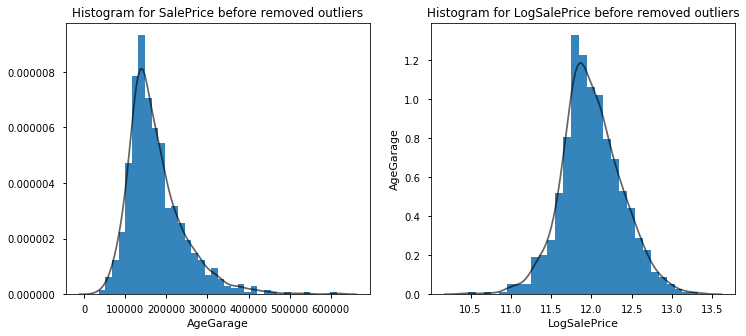

In [18]:
#Histogram of SalePrice and LogSalePrice before removed outliers.

fig,ax=plt.subplots(1,2,figsize=(12,5))
sns.distplot(data['SalePrice'],ax=ax[0],hist_kws={'alpha':0.9},kde_kws={'color':'black','alpha':0.6})
ax[0].set(title='Histogram for SalePrice before removed outliers', xlabel=i)
sns.distplot(data['LogSalePrice'],ax=ax[1],hist_kws={'alpha':0.9},kde_kws={'color':'black','alpha':0.6})
ax[1].set(title='Histogram for LogSalePrice before removed outliers', ylabel=i)
#fig.savefig('histogram for saleprice before and after removed outliers.png')

[<matplotlib.text.Text at 0x11f013a90>, <matplotlib.text.Text at 0x11f804780>]

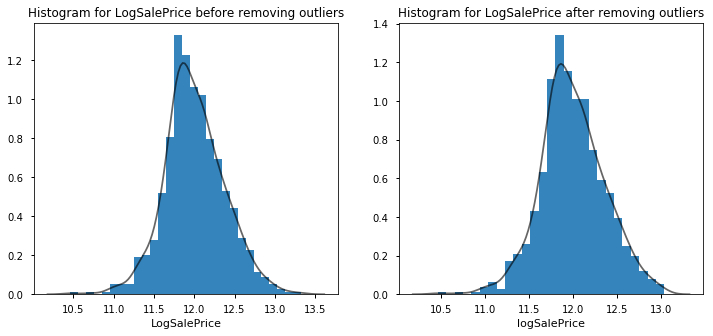

In [19]:
#Histogram of SalePrice and LogSalePrice after removed outliers.

fig,ax=plt.subplots(1,2,figsize=(12,5))
sns.distplot(data['LogSalePrice'],ax=ax[0],hist_kws={'alpha':0.9},kde_kws={'color':'black','alpha':0.6})
ax[0].set(title='Histogram for LogSalePrice before removing outliers', xlabel='LogSalePrice')
sns.distplot(data_removed_outliers['LogSalePrice'],ax=ax[1],hist_kws={'alpha':0.9},kde_kws={'color':'black','alpha':0.6})
ax[1].set(title='Histogram for LogSalePrice after removing outliers', xlabel='logSalePrice')
# fig.savefig('Histogram for SalePrice and logSalePrice.png'

In [20]:
#Set transformed data set, data_removed_outliers, as main data.

data = data_removed_outliers

In [ ]:
#Draw regression plots for all continuous variables and save the results as picture.
#Some variables which have a linear relationship with SalePrice are MasVnrArea, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageArea.
#Some variables which have a non-linear relationship with SalePrice are BsmtFinSF1, OpenporchSF.
#There could still be some outliers.

for i in Continuous:
    fig,ax=plt.subplots(1,1,figsize=(12,5))
    sns.regplot(data[i], data['LogSalePrice'], scatter_kws = {'s': 25}, lowess=True, color=sns.color_palette('Blues')[-1])
    sns.despine()
    ax.set(ylabel='LogSalePrice', title='Scatter plot for {}'.format(i))
    plt.show()
    #fig.savefig('{}.png'.format(i))

In [22]:
#Print number of non-zero values for continuous variables.
#LowQualFinSF, 3SsnPorch, PoolArea, MiscVal have only a little non-zero values so the sample size is insufficient.

print('the number of non-zero value for each continuous varible')
for i in Continuous:
    count = 0
    for m in data[i]:
        if m != 0:
            count += 1
    print('{}:{}'.format(i,count))

the number of non-zero value for each continuous varible
LotFrontage:640
LotArea:797
MasVnrArea:305
BsmtFinSF1:567
BsmtFinSF2:107
BsmtUnfSF:730
TotalBsmtSF:776
1stFlrSF:797
2ndFlrSF:341
LowQualFinSF:8
GrLivArea:797
GarageArea:762
WoodDeckSF:374
OpenPorchSF:415
EnclosedPorch:133
3SsnPorch:12
ScreenPorch:70
PoolArea:2
MiscVal:22
SalePrice:797
AgeHouse:789
AgeGarage:760


#### Discrete variables

In [ ]:
#Plot histograms and box plots for discrete variables and save output as picture.

for i in Discrete:
    fig,ax=plt.subplots(1,2,figsize=(12,5))
    ax[0].set(title='Histogram for {}'.format(i), xlabel=i)
    sns.distplot(data[i],ax=ax[0],hist_kws={'alpha':0.9},kde_kws={'color':'black','alpha':0.6})
    ax[1].set(title='Boxplot for {}'.format(i), xlabel=i)
    sns.boxplot(data[i],orient='v',ax=ax[1])
    #fig.savefig('{}.png'.format(i))

In [24]:
#Create table to describe data for discrete variables.

table = data[Discrete].describe()
table.loc['skewness']= data.skew()
table.loc['kurtosis']= data.kurt()
table.round(2)

,YearRemod/Add,YearBuilt,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,MoSold,YrSold
count,797.00,797.00,797.00,797.00,797.00,797.00,797.00,797.00,797.00,797.00,797.00,797.00
mean,1982.84,1969.50,0.44,1.51,0.37,2.82,1.05,6.33,0.61,1.72,6.01,2007.90
std,20.59,28.47,0.52,0.53,0.50,0.82,0.22,1.47,0.65,0.72,2.62,1.32
min,1950.00,1879.00,0.00,0.00,0.00,0.00,1.00,3.00,0.00,0.00,1.00,2006.00
25%,1964.00,1953.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1.00,4.00,2007.00
50%,1990.00,1971.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,2.00,6.00,2008.00
75%,2002.00,1997.00,1.00,2.00,1.00,3.00,1.00,7.00,1.00,2.00,7.00,2009.00
max,2010.00,2009.00,2.00,4.00,2.00,6.00,3.00,13.00,3.00,4.00,12.00,2010.00
skewness,-0.37,-0.52,0.45,0.25,0.68,0.05,4.69,0.64,0.69,-0.17,0.36,0.01
kurtosis,-1.39,-0.48,-1.29,-0.80,-1.16,1.15,22.09,0.93,-0.19,0.30,-0.20,-1.16


In [ ]:
#Create regression plots of discrete variables and save output.
#There is an approximately linear trend for almost all discrete variables, except for YrSold, MoSold (as expected) and KitchenAbvGr.
#FullBath, GarageCars, TotRmsAbrGrd, BedroomAbvGr have non-linear trends in the box plots. 
#However, the sample size for some classes is insufficient. 
#Those variables are likely to have linear relationship with saleprice, if sample size is large enough.

for i in Discrete:
    fig,ax=plt.subplots(1,1,figsize=(12,5))
    sns.regplot(data[i], data['LogSalePrice'], scatter_kws = {'s': 25}, lowess=True, color=sns.color_palette('Blues')[-1])
    sns.despine()
    ax.set(ylabel='LogSalePrice', title = 'Scatter plot for {}'.format(i))
    plt.show()
    #fig.savefig('{}.png'.format(i))

In [26]:
#Category count for those discrete variables that don't seem to have linear trends.

def count(cata_var):
    count = {}
    for i in cata_var.unique():
        count[i] = 0 
        for j in cata_var:
            if j == i:
                count[i] += 1
    return count

non_linear_discrete = ['FullBath', 'GarageCars', 'TotRmsAbvGrd', 'BedroomAbvGr']
for i in non_linear_discrete:
    print('{}:{}'.format(i,count(data[i])))

FullBath:{1: 396, 2: 389, 3: 9, 0: 2, 4: 1}
GarageCars:{1.0: 237, 2.0: 444, 3.0: 77, 0.0: 35, 4.0: 4}
TotRmsAbvGrd:{6: 213, 8: 90, 5: 182, 7: 190, 10: 11, 4: 56, 3: 7, 9: 39, 11: 6, 12: 2, 13: 1}
BedroomAbvGr:{3: 429, 4: 108, 2: 208, 1: 33, 0: 3, 5: 13, 6: 3}


#### Ordinal Variables

In [ ]:
#Draw box plots for ordinal variables and save output as picture.
#There is linear trend for Quality variables (OverallQual, KitchenQual, FireplaceQC, etc.)
#Treat them as numerical rather than nominal or ordinal.

for i in Ordinal:
    fig, ax= plt.subplots()
    sns.boxplot(data[i], data['LogSalePrice'], ax=ax, palette='Blues')
    ax.set(ylabel='LogSalePrice', title='Boxplot for {}'.format(i))
    plt.tight_layout()
    plt.show()
    #fig.savefig('{}.png'.format(i))

In [ ]:
#Box plots of all "quality" variables and graphed in ascending order and saved as pictures.

Quality_terms = ['ExterQual', 'BsmtQual', 'BsmtExposure', 'KitchenQual', 'FireplaceQu', 
                 'GarageQual', 'HeatingQC', 'GarageCond', 'BsmtCond', 'ExterCond']
Order1 = ['NA','Po','Fa','TA','Gd','Ex']
Order2 = ['NA','No','Mn','Av','Gd']
for i in Quality_terms:
    if i != 'BsmtExposure':
        fig, ax= plt.subplots()
        sns.boxplot(data[i], data['LogSalePrice'], ax=ax, order = Order1, palette='Blues')
        ax.set(ylabel='LogSalePrice', title='Boxplot for {}'.format(i))
        plt.tight_layout()
        plt.show()
        #fig.savefig('{} in order.png'.format(i))
    if i == 'BsmtExposure':
        fig, ax= plt.subplots()
        sns.boxplot(data[i], data['LogSalePrice'], ax=ax, order = Order2, palette='Blues')
        ax.set(ylabel='LogSalePrice', title='Boxplot for {}'.format(i))
        plt.tight_layout()
        plt.show()
        #fig.savefig('{} in order.png'.format(i))

In [29]:
#Count data breakdown by catagory/class.
#For some classes in a variable, the sample size is insufficient.

for i in Ordinal:
    print('{}:{}'.format(i,count(data[i])))

Utilities:{'AllPub': 796, 'NoSewr': 1}
LotShape:{'IR1': 272, 'Reg': 502, 'IR2': 21, 'IR3': 2}
LandSlope:{'Gtl': 754, 'Mod': 38, 'Sev': 5}
OverallQual:{5: 246, 7: 146, 6: 220, 8: 93, 4: 58, 9: 17, 3: 11, 2: 4, 10: 2}
OverallCond:{8: 49, 5: 414, 6: 171, 7: 113, 4: 27, 3: 15, 9: 8}
ExterQual:{'Gd': 239, 'TA': 535, 'Fa': 10, 'Ex': 13}
ExterCond:{'Gd': 93, 'TA': 687, 'Fa': 14, 'Ex': 3}
BsmtQual:{'TA': 389, 'Fa': 19, 'Gd': 316, 'Ex': 51, 'NA': 21, 'Po': 1}
BsmtCond:{'TA': 722, 'Fa': 26, 'Gd': 26, 'NA': 21, 'Ex': 1, 'Po': 1}
BsmtExposure:{'No': 527, 'Mn': 75, 'Av': 104, 'Gd': 69, 'NA': 22}
BsmtFinType1:{'ALQ': 138, 'Rec': 83, 'GLQ': 220, 'Unf': 209, 'BLQ': 78, 'LwQ': 48, 'NA': 21}
BsmtFinType2:{'Unf': 669, 'ALQ': 13, 'Rec': 33, 'LwQ': 23, 'GLQ': 13, 'NA': 21, 'BLQ': 25}
HeatingQC:{'Ex': 378, 'TA': 245, 'Gd': 148, 'Fa': 26}
Electrical:{'SBrkr': 721, 'FuseA': 62, 'FuseF': 12, 'FuseP': 2}
KitchenQual:{'TA': 444, 'Gd': 302, 'Ex': 32, 'Fa': 18, 'Po': 1}
Functional:{'Typ': 739, 'Min1': 26, 'Maj1': 

### Nominal Variables

In [ ]:
#Box plots of remaining nominal variables.

for i in Nominal:
    fig, ax= plt.subplots()
    sns.boxplot(data[i], data['LogSalePrice'], data=data, ax=ax, palette='Blues')
    ax.set(ylabel='LogSalePrice', title='Boxplot for {}'.format(i))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    #fig.savefig('boxplots for nominal {}.png'.format(i))

In [31]:
#Count data breakdown by category.

for i in Nominal:
    print('{}:{}'.format(i,count(data[i])))

MSSubClass:{'20': 291, '60': 146, '160': 40, '75': 6, '50': 84, '30': 40, '90': 31, '180': 7, '190': 12, '120': 47, '70': 37, '80': 31, '85': 18, '40': 2, '45': 4, '150': 1}
MSZoning:{'RL': 622, 'FV': 38, 'RM': 124, 'RH': 9, 'C (all)': 3, 'I (all)': 1}
Street:{'Pave': 793, 'Grvl': 4}
Alley:{'NA': 742, 'Pave': 23, 'Grvl': 32}
LandContour:{'Lvl': 722, 'Bnk': 26, 'HLS': 31, 'Low': 18}
LotConfig:{'CulDSac': 49, 'Inside': 574, 'Corner': 149, 'FR2': 20, 'FR3': 5}
Neighborhood:{'CollgCr': 72, 'Edwards': 55, 'Somerst': 46, 'OldTown': 66, 'Gilbert': 37, 'NridgHt': 26, 'BrkSide': 28, 'Timber': 15, 'IDOTRR': 15, 'Veenker': 11, 'NoRidge': 22, 'NAmes': 136, 'SawyerW': 31, 'Sawyer': 41, 'NWAmes': 43, 'Blueste': 4, 'MeadowV': 10, 'Mitchel': 44, 'BrDale': 11, 'ClearCr': 18, 'StoneBr': 10, 'Crawfor': 30, 'Blmngtn': 5, 'SWISU': 12, 'NPkVill': 7, 'Greens': 2}
Condition1:{'Norm': 694, 'Feedr': 37, 'RRAn': 7, 'Artery': 29, 'PosN': 14, 'RRAe': 7, 'PosA': 4, 'RRNn': 3, 'RRNe': 2}
Condition2:{'Norm': 793, 'Ar

In [32]:
#Convert month to string because it is stored as numerical, but not treated as numerical.

data['MoSold'] = data['MoSold'].astype(str) 

#Delete year built, remodeled, and garage year built.

del data['YearBuilt']
del data['YearRemod/Add']
del data['GarageYrBlt']

In [33]:
#Duplicate data to keep record of previous version in case need to use it.

data_num = data.copy()

In [34]:
#Sort neighborhoods by mean.

neighbor_mean = data_num.groupby('Neighborhood')[['SalePrice']].apply(np.mean)
neighbor_mean.sort_values('SalePrice')

,SalePrice
Neighborhood,
MeadowV,89790.000000
BrDale,109272.727273
IDOTRR,111095.000000
OldTown,123706.818182
Edwards,126203.636364
SWISU,126291.666667
BrkSide,126909.821429
Sawyer,135542.878049
NAmes,143742.117647


In [35]:
#Import scip to compare Neighborhood Categories with Welch's t-tests assuming unequal variance.
#Group categories accordingly to decrease number of neighborhood categories.
#Significance level 10%

from scipy import stats

#Leave MeadowV

t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='MeadowV','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='BrDale','SalePrice'],equal_var=False)
print('MeadowV vs BrDale',pvalue)

#Combine BrDale and IDOTRR

t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='BrDale','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='IDOTRR','SalePrice'],equal_var=False)
print('BrDale vs IDOTRR',pvalue)

#Combine OldTown Edwards SWISU BrkSide

t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='OldTown','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='Edwards','SalePrice'],equal_var=False)
print('OldTown vs Edwards',pvalue) 
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='OldTown','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='SWISU','SalePrice'],equal_var=False)
print('OldTown vs SWISU',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='OldTown','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='BrkSide','SalePrice'],equal_var=False)
print('OldTown vs BrkSide',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Edwards','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='SWISU','SalePrice'],equal_var=False)
print('Edwards vs SWISU',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Edwards','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='BrkSide','SalePrice'],equal_var=False)
print('Edwards vs BrkSide',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='SWISU','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='BrkSide','SalePrice'],equal_var=False)
print('SWISU vs BrkSide',pvalue)

#Combine Sawyer NAmes Blueste NPkVill

t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Sawyer','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='NAmes','SalePrice'],equal_var=False)
print('Sawyer vs NAmes',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Sawyer','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='Blueste','SalePrice'],equal_var=False)
print('Sawyer vs Blueste',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Sawyer','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='NPkVill','SalePrice'],equal_var=False)
print('Sawyer vs NPkVill',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='NAmes','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='Blueste','SalePrice'],equal_var=False)
print('NAmes vs Blueste',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='NAmes','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='NPkVill','SalePrice'],equal_var=False)
print('NAmes vs NPkVill',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Blueste','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='NPkVill','SalePrice'],equal_var=False)
print('Blueste vs NPkVill',pvalue)

#Combine Mitchel SawyerW Blmngtn

t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Mitchel','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='SawyerW','SalePrice'],equal_var=False)
print('Mitchel vs SawyerW',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Mitchel','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='Blmngtn','SalePrice'],equal_var=False)
print('Mitchel vs Blmngtn',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='SawyerW','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='Blmngtn','SalePrice'],equal_var=False)
print('SawyerW vs Blmgtn',pvalue)

#Combine Gilbert NWAmes Crawfor CollgCr

t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Gilbert','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='NWAmes','SalePrice'],equal_var=False)
print('Gilbert vs NWAmes',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Gilbert','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='Crawfor','SalePrice'],equal_var=False)
print('Gilbert vs Crawfor',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Gilbert','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='CollgCr','SalePrice'],equal_var=False)
print('Gilbert vs CollgCr',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='NWAmes','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='Crawfor','SalePrice'],equal_var=False)
print('NWAmes vs Crawfor',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='NWAmes','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='CollgCr','SalePrice'],equal_var=False)
print('NWAmes vs CollgCr',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Crawfor','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='CollgCr','SalePrice'],equal_var=False)
print('Crawfor vs CollgCr',pvalue)

#Combine Greens ClearCr Somerst Timber

t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Greens','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='ClearCr','SalePrice'],equal_var=False)
print('Greens vs ClearCr',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Greens','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='Somerst','SalePrice'],equal_var=False)
print('Greens vs Somerst',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Greens','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='Timber','SalePrice'],equal_var=False)
print('Greens vs Timber',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='ClearCr','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='Somerst','SalePrice'],equal_var=False)
print('ClearCr vs Somerst',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='ClearCr','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='Timber','SalePrice'],equal_var=False)
print('ClearCr vs Timber',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Somerst','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='Timber','SalePrice'],equal_var=False)
print('Somerst vs Timber',pvalue)

#Leave Veenker

t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='Veenker','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='StoneBr','SalePrice'],equal_var=False)
print('Veenker vs StoneBr',pvalue)

#Combine StoneBr NoRidge NridgHt

t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='StoneBr','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='NoRidge','SalePrice'],equal_var=False)
print('StoneBr vs NoRidge',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='StoneBr','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='NridgHt','SalePrice'],equal_var=False)
print('StoneBr vs NridgHt',pvalue)
t, pvalue = stats.ttest_ind(data_num.loc[data_num['Neighborhood']=='NoRidge','SalePrice'],
                            data_num.loc[data_num['Neighborhood']=='NridgHt','SalePrice'],equal_var=False)
print('NoRidge vs NridgHt',pvalue)

MeadowV vs BrDale 0.00682063650341
BrDale vs IDOTRR 0.871850888233
OldTown vs Edwards 0.693259730077
OldTown vs SWISU 0.711552688739
OldTown vs BrkSide 0.674443060196
Edwards vs SWISU 0.991399976305
Edwards vs BrkSide 0.935532808136
SWISU vs BrkSide 0.946338598138
Sawyer vs NAmes 0.0904580917132
Sawyer vs Blueste 0.693463657761
Sawyer vs NPkVill 0.0302955488708
NAmes vs Blueste 0.990184625832
NAmes vs NPkVill 0.542413647079
Blueste vs NPkVill 0.936619165103
Mitchel vs SawyerW 0.418146957705
Mitchel vs Blmngtn 0.352999512298
SawyerW vs Blmgtn 0.826452005165
Gilbert vs NWAmes 0.849032255937
Gilbert vs Crawfor 0.563579481088
Gilbert vs CollgCr 0.0756164566016
NWAmes vs Crawfor 0.678561192944
NWAmes vs CollgCr 0.175689311425
Crawfor vs CollgCr 0.560713043157
Greens vs ClearCr 0.913179441772
Greens vs Somerst 0.233012182493
Greens vs Timber 0.515151290917
ClearCr vs Somerst 0.618752817881
ClearCr vs Timber 0.64448821435
Somerst vs Timber 0.892548459827
Veenker vs StoneBr 0.634021019886
Ston

#### Correlation Matrix

In [36]:
#Show top 25 numerical variables by correlation to LogSalePrice.

pd.set_option('display.max_rows',300)
abs_correl = abs(data_num.corr().round(3)['LogSalePrice'])
abs_correl_sort = abs_correl.sort_values(ascending=False)
abs_correl_sort.head(27)
pd.DataFrame(abs_correl_sort.head(27))

,LogSalePrice
LogSalePrice,1.000
SalePrice,0.965
OverallQual,0.811
GrLivArea,0.727
GarageCars,0.671
GarageArea,0.662
TotalBsmtSF,0.616
1stFlrSF,0.596
AgeHouse,0.546
FullBath,0.543


In [37]:
#Get list so easy to copy and paste into cell below. Use 27 to get top 25 for correlation heatmap.

abs_correl_sort.head(27).index

Index(['LogSalePrice', 'SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'AgeHouse', 'FullBath',
       'Fireplaces', 'TotRmsAbvGrd', 'BsmtFinSF1', 'AgeGarage', 'MasVnrArea',
       'WoodDeckSF', 'HalfBath', 'OpenPorchSF', '2ndFlrSF', 'LotArea',
       'BsmtFullBath', 'BedroomAbvGr', 'BsmtUnfSF', 'EnclosedPorch',
       'KitchenAbvGr', 'LotFrontage', 'ScreenPorch'],
      dtype='object')

In [38]:
#Put top 25 numerical variables in a list.

top_variables_25 = ['LogSalePrice', 'OverallQual', 'GrLivArea', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'AgeHouse', 'FullBath',
       'Fireplaces', 'TotRmsAbvGrd', 'BsmtFinSF1', 'AgeGarage', 'MasVnrArea',
       'WoodDeckSF', 'HalfBath', 'OpenPorchSF', '2ndFlrSF', 'LotArea',
       'BsmtFullBath', 'BedroomAbvGr', 'BsmtUnfSF', 'EnclosedPorch',
       'KitchenAbvGr', 'LotFrontage', 'ScreenPorch']

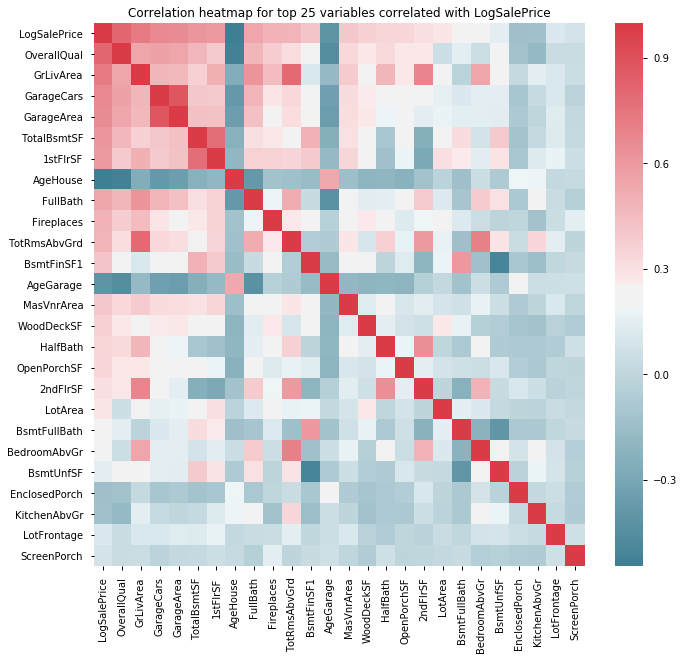

In [39]:
#Create heatmap of top 25 numerical variables. Note this is before dummy variable creation and simply to have an idea of
#numerical relationships.

data_num[top_variables_25].corr().round(4)
fig, ax = plt.subplots(figsize = (11,10))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(data_num[top_variables_25].corr(), ax=ax, cmap=cmap)
ax.set(title='Correlation heatmap for top 25 variables correlated with LogSalePrice')
#fig.savefig('Correlation heatmap before feature engineering (top 25).png')

## Feature Engineering

In [40]:
#Combine Neighborhood variables using results from Welch's t-tests in EDA.

neighbor_combined = {'MeadowV':'MeadowV',
                     'BrDale': 'BrD_IDO',
                     'IDOTRR': 'BrD_IDO',
                     'OldTown':'Old_Ed_SW_Brk',
                     'Edwards':'Old_Ed_SW_Brk',
                     'SWISU':'Old_Ed_SW_Brk',
                     'BrkSide':'Old_Ed_SW_Brk',
                     'Sawyer':'Sa_NA_Bl_NP',
                     'NAmes':'Sa_NA_Bl_NP',
                     'Blueste':'Sa_NA_Bl_NP',
                     'NPkVill':'Sa_NA_Bl_NP',
                     'Mitchel':'Mi_SaW,Bng',
                     'SawyerW':'Mi_SaW,Bng',
                     'Blmngtn':'Mi_SaW,Bng',
                     'Gilbert':'Gi_NWA_Cr_Co',
                     'NWAmes':'Gi_NWA_Cr_Co',
                     'Crawfor':'Gi_NWA_Cr_Co',
                     'CollgCr':'Gi_NWA_Cr_Co',
                     'Greens':'Gr_CC_So_Ti',
                     'ClearCr':'Gr_CC_So_Ti',
                     'Somerst':'Gr_CC_So_Ti',
                     'Timber':'Gr_CC_So_Ti',
                     'Veenker':'Veenker',
                     'StoneBr':'St_No_NHt',
                     'NoRidge':'St_No_NHt',
                     'NridgHt':'St_No_NHt'}
data_num['Neighborhood'] = data_num['Neighborhood'].map(neighbor_combined)

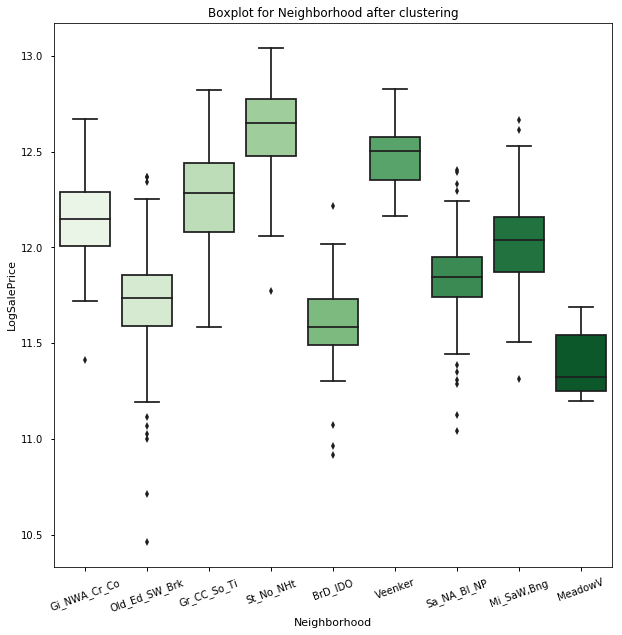

In [41]:
#Box plots of neighborhood after combining neighborhoods.

fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x = 'Neighborhood' , y = 'LogSalePrice', ax = ax, data = data_num, palette = 'Greens')
plt.xticks(rotation=20)
ax.set(title='Boxplot for Neighborhood after clustering')
#fig.savefig('Boxplot for Neighborhood after clustering.png')
plt.show()

In [42]:
#Recode and convert quality type ordinals to numerical for more simplicity in analysis.

exterqual_vals = {'Fa':1,'TA':2,'Gd':3,'Ex':4}
data_num['ExterQual'] = data_num['ExterQual'].map(exterqual_vals).astype(int)

bsmt_vals = {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
data_num['BsmtQual'] = data_num['BsmtQual'].map(bsmt_vals).astype(int)

bsmt_exp = {'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4}
data_num['BsmtExposure'] = data_num['BsmtExposure'].map(bsmt_exp).astype(int)

kitchen_vals = {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
data_num['KitchenQual'] = data_num['KitchenQual'].map(kitchen_vals).astype(int)

fireplace_qual = {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
data_num['FireplaceQu'] = data_num['FireplaceQu'].map(fireplace_qual).astype(int)

garage_vals= {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4}
data_num['GarageQual'] = data_num['GarageQual'].map(garage_vals).astype(int)

heating_vals = {'Fa':1,'TA':2,'Gd':3,'Ex':4}
data_num['HeatingQC'] = data_num['HeatingQC'].map(kitchen_vals).astype(int)

garage_cond = {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4}
data_num['GarageCond'] = data_num['GarageCond'].map(garage_cond).astype(int)

bsmt_cond = {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
data_num['BsmtCond'] = data_num['BsmtCond'].map(bsmt_cond).astype(int)

exter_cond = {'Fa':1,'TA':2,'Gd':3,'Ex':4}
data_num['ExterCond'] = data_num['ExterCond'].map(exter_cond).astype(int)

In [43]:
#Create dummy variables for remaining categoricals.

columns_cat_num = list(data_num.select_dtypes(['object']).columns)
for column in columns_cat_num:
    data_num = pd.get_dummies(data_num, columns = [column])

In [44]:
#Create interactions. GrLiv_Rooms created but ultimately left out.

data_num['BsmtSF_Qual'] = data_num['TotalBsmtSF']*data_num['BsmtQual']
data_num['GarageArea_Qual'] = data_num['GarageArea']*data_num['GarageQual']
#data_num['GrLiv_Rooms'] = data_num['GrLivArea']*data_num['TotRmsAbvGrd']
data_num['GarageArea_Cars'] = data_num['GarageArea']*data_num['GarageCars']

## Further EDA - Correlation Matrix with Interaction Terms

In [45]:
#Show top 70 correlated with LogSalePrice

pd.set_option('display.max_rows',300)
abs_correl = abs(data_num.corr().round(3)['LogSalePrice'])
abs_correl_sort = abs_correl.sort_values(ascending=False)
abs_correl_sort.head(72)

LogSalePrice                  1.000
SalePrice                     0.965
OverallQual                   0.811
BsmtSF_Qual                   0.728
GrLivArea                     0.727
GarageCars                    0.671
GarageArea_Cars               0.669
GarageArea_Qual               0.669
GarageArea                    0.662
ExterQual                     0.636
BsmtQual                      0.616
TotalBsmtSF                   0.616
KitchenQual                   0.616
1stFlrSF                      0.596
AgeHouse                      0.546
FullBath                      0.543
FireplaceQu                   0.533
Foundation_PConc              0.530
Fireplaces                    0.492
TotRmsAbvGrd                  0.482
Neighborhood_St_No_NHt        0.470
HeatingQC                     0.465
GarageType_Attchd             0.444
GarageFinish_Unf              0.429
BsmtFinType1_GLQ              0.421
GarageType_Detchd             0.416
BsmtFinSF1                    0.414
AgeGarage                   

In [46]:
#Print list so easy to copy and paste in cell below.

abs_correl_sort.head(72).index

Index(['LogSalePrice', 'SalePrice', 'OverallQual', 'BsmtSF_Qual', 'GrLivArea',
       'GarageCars', 'GarageArea_Cars', 'GarageArea_Qual', 'GarageArea',
       'ExterQual', 'BsmtQual', 'TotalBsmtSF', 'KitchenQual', '1stFlrSF',
       'AgeHouse', 'FullBath', 'FireplaceQu', 'Foundation_PConc', 'Fireplaces',
       'TotRmsAbvGrd', 'Neighborhood_St_No_NHt', 'HeatingQC',
       'GarageType_Attchd', 'GarageFinish_Unf', 'BsmtFinType1_GLQ',
       'GarageType_Detchd', 'BsmtFinSF1', 'AgeGarage',
       'Neighborhood_Old_Ed_SW_Brk', 'MSSubClass_60', 'MasVnrArea',
       'CentralAir_Y', 'CentralAir_N', 'PavedDrive_Y', 'Exterior1st_VinylSd',
       'Exterior2nd_VinylSd', 'GarageQual', 'BsmtExposure', 'PavedDrive_N',
       'MSZoning_RM', 'WoodDeckSF', 'GarageFinish_Fin', 'LotShape_Reg',
       'GarageCond', 'MasVnrType_None', 'HalfBath', 'MSSubClass_30',
       'OpenPorchSF', 'Electrical_SBrkr', 'LotShape_IR1', 'Foundation_CBlock',
       '2ndFlrSF', 'GarageType_NA', 'GarageFinish_NA', 'BsmtCond',


In [47]:
#List used for large 70 variable correlation heatmap.

predictors_heat_large = ['LogSalePrice', 'OverallQual', 'BsmtSF_Qual', 'GrLivArea',
       'GarageCars', 'GarageArea_Cars', 'GarageArea_Qual', 'GarageArea',
       'ExterQual', 'BsmtQual', 'TotalBsmtSF', 'KitchenQual', '1stFlrSF',
       'AgeHouse', 'FullBath', 'FireplaceQu', 'Foundation_PConc', 'Fireplaces',
       'TotRmsAbvGrd', 'Neighborhood_St_No_NHt', 'HeatingQC',
       'GarageType_Attchd', 'GarageFinish_Unf', 'BsmtFinType1_GLQ',
       'GarageType_Detchd', 'BsmtFinSF1', 'AgeGarage',
       'Neighborhood_Old_Ed_SW_Brk', 'MSSubClass_60', 'MasVnrArea',
       'CentralAir_Y', 'CentralAir_N', 'PavedDrive_Y', 'Exterior1st_VinylSd',
       'Exterior2nd_VinylSd', 'GarageQual', 'BsmtExposure', 'PavedDrive_N',
       'MSZoning_RM', 'WoodDeckSF', 'GarageFinish_Fin', 'LotShape_Reg',
       'GarageCond', 'MasVnrType_None', 'HalfBath', 'MSSubClass_30',
       'OpenPorchSF', 'Electrical_SBrkr', 'LotShape_IR1', 'Foundation_CBlock',
       '2ndFlrSF', 'GarageType_NA', 'GarageFinish_NA', 'BsmtCond',
       'MSZoning_RL', 'GarageFinish_RFn', 'LotArea', 'MasVnrType_BrkFace',
       'Foundation_BrkTil', 'HouseStyle_2Story', 'Neighborhood_Gr_CC_So_Ti',
       'BsmtFullBath', 'Electrical_FuseA', 'Neighborhood_Sa_NA_Bl_NP',
       'BsmtFinType1_NA', 'BsmtFinType2_NA', 'MasVnrType_Stone',
       'Neighborhood_Gi_NWA_Cr_Co', 'Neighborhood_BrD_IDO', 'BedroomAbvGr',
       'Fence_NA']

#List used for smaller 30 variable correlation heatmap.

predictors_heat = ['LogSalePrice', 'OverallQual', 'BsmtSF_Qual', 'GrLivArea',
                   'GarageCars', 'GarageArea_Cars', 'GarageArea_Qual', 'GarageArea',
                   'ExterQual', 'BsmtQual', 'TotalBsmtSF', 'KitchenQual', '1stFlrSF',
                   'AgeHouse', 'FullBath', 'FireplaceQu', 'Foundation_PConc', 'Fireplaces',
                   'TotRmsAbvGrd', 'Neighborhood_St_No_NHt', 'HeatingQC',
                   'GarageType_Attchd', 'GarageFinish_Unf', 'BsmtFinType1_GLQ',
                   'GarageType_Detchd', 'BsmtFinSF1', 'AgeGarage',
                   'Neighborhood_Old_Ed_SW_Brk', 'MSSubClass_60', 'MasVnrArea',
                   'CentralAir_Y']


#Predictors used for OLS model.
#Started with 30 and removed GarageArea_Qual, Fireplaces, TotRmsAbvGrd, GarageType_Detchd, 1stFlrSF.

predictors1 = ['OverallQual', 'BsmtSF_Qual', 'GrLivArea', 'GarageCars', 'GarageArea_Cars', 
                'GarageArea', 'ExterQual', 'BsmtQual', 'TotalBsmtSF', 'KitchenQual',
                'AgeHouse', 'FullBath', 'FireplaceQu', 'Foundation_PConc','Neighborhood_St_No_NHt', 
                'HeatingQC', 'GarageType_Attchd', 'GarageFinish_Unf', 'BsmtFinType1_GLQ',
                'BsmtFinSF1', 'AgeGarage', 'Neighborhood_Old_Ed_SW_Brk', 'MSSubClass_60', 
                'MasVnrArea', 'CentralAir_Y']

#Predictors used for Fwd + Ridge, Lasso, Enet, and Fwd + PCR models.
#Started with 70 and removed GarageArea_Qual, Fireplaces, TotRmsAbvGrd, GarageType_Detchd, 1stFlrSF, CentralAir_N, PavedDrive_N, 
#GarageCond, LotShape_IR1, Foundation_CBlock, 2ndFlrSF, GarageType_NA, GarageFinish_NA, BsmtCond, MSZoning_RL, BsmtFullBath
#MasVnrType_BrkFace, HouseStyle_2Story, Electrical_FuseA

predictors2 = ['OverallQual', 'BsmtSF_Qual', 'GrLivArea',
       'GarageCars', 'GarageArea_Cars', 'GarageArea',
       'ExterQual', 'BsmtQual', 'TotalBsmtSF', 'KitchenQual',
       'AgeHouse', 'FullBath', 'FireplaceQu', 'Foundation_PConc',
       'Neighborhood_St_No_NHt', 'HeatingQC',
       'GarageType_Attchd', 'GarageFinish_Unf', 'BsmtFinType1_GLQ',
       'BsmtFinSF1', 'AgeGarage',
       'Neighborhood_Old_Ed_SW_Brk', 'MSSubClass_60', 'MasVnrArea',
       'CentralAir_Y', 'PavedDrive_Y', 'Exterior1st_VinylSd',
       'Exterior2nd_VinylSd', 'GarageQual', 'BsmtExposure',
       'MSZoning_RM', 'WoodDeckSF', 'GarageFinish_Fin', 'LotShape_Reg',
       'MasVnrType_None', 'HalfBath', 'MSSubClass_30',
       'OpenPorchSF', 'Electrical_SBrkr',
       'GarageFinish_RFn', 'LotArea',
       'Foundation_BrkTil', 'Neighborhood_Gr_CC_So_Ti',
       'Neighborhood_Sa_NA_Bl_NP',
       'BsmtFinType1_NA', 'BsmtFinType2_NA', 'MasVnrType_Stone',
       'Neighborhood_Gi_NWA_Cr_Co', 'Neighborhood_BrD_IDO', 'BedroomAbvGr',
       'Fence_NA']

In [48]:
#Display correlations of top 70.

pd.set_option('display.max_columns',71)
data_num[predictors_heat_large].corr().round(3)

,LogSalePrice,OverallQual,BsmtSF_Qual,GrLivArea,GarageCars,GarageArea_Cars,GarageArea_Qual,GarageArea,ExterQual,BsmtQual,TotalBsmtSF,KitchenQual,1stFlrSF,AgeHouse,FullBath,FireplaceQu,Foundation_PConc,Fireplaces,TotRmsAbvGrd,Neighborhood_St_No_NHt,HeatingQC,GarageType_Attchd,GarageFinish_Unf,BsmtFinType1_GLQ,GarageType_Detchd,BsmtFinSF1,AgeGarage,Neighborhood_Old_Ed_SW_Brk,MSSubClass_60,MasVnrArea,CentralAir_Y,CentralAir_N,PavedDrive_Y,Exterior1st_VinylSd,Exterior2nd_VinylSd,GarageQual,BsmtExposure,PavedDrive_N,MSZoning_RM,WoodDeckSF,GarageFinish_Fin,LotShape_Reg,GarageCond,MasVnrType_None,HalfBath,MSSubClass_30,OpenPorchSF,Electrical_SBrkr,LotShape_IR1,Foundation_CBlock,2ndFlrSF,GarageType_NA,GarageFinish_NA,BsmtCond,MSZoning_RL,GarageFinish_RFn,LotArea,MasVnrType_BrkFace,Foundation_BrkTil,HouseStyle_2Story,Neighborhood_Gr_CC_So_Ti,BsmtFullBath,Electrical_FuseA,Neighborhood_Sa_NA_Bl_NP,BsmtFinType1_NA,BsmtFinType2_NA,MasVnrType_Stone,Neighborhood_Gi_NWA_Cr_Co,Neighborhood_BrD_IDO,BedroomAbvGr,Fence_NA
LogSalePrice,1.000,0.811,0.728,0.727,0.671,0.669,0.669,0.662,0.636,0.616,0.616,0.616,0.596,-0.546,0.543,0.533,0.530,0.492,0.482,0.470,0.465,0.444,-0.429,0.421,-0.416,0.414,-0.411,-0.410,0.410,0.407,0.390,-0.390,0.379,0.377,0.376,0.372,0.369,-0.369,-0.368,0.367,0.363,-0.360,0.358,-0.357,0.347,-0.337,0.336,0.326,0.322,-0.321,0.307,-0.304,-0.304,0.294,0.282,0.279,0.276,0.272,-0.268,0.260,0.256,0.254,-0.246,-0.236,-0.231,-0.231,0.229,0.229,-0.216,0.200,0.197
OverallQual,0.811,1.000,0.630,0.546,0.565,0.571,0.548,0.543,0.684,0.623,0.474,0.621,0.396,-0.528,0.478,0.456,0.562,0.381,0.313,0.463,0.422,0.365,-0.421,0.418,-0.346,0.240,-0.458,-0.320,0.339,0.333,0.330,-0.330,0.309,0.360,0.361,0.275,0.312,-0.300,-0.224,0.272,0.314,-0.299,0.270,-0.328,0.326,-0.266,0.275,0.280,0.271,-0.398,0.275,-0.227,-0.227,0.282,0.116,0.280,0.054,0.228,-0.197,0.276,0.246,0.144,-0.211,-0.294,-0.226,-0.226,0.258,0.192,-0.122,0.048,0.205
BsmtSF_Qual,0.728,0.630,1.000,0.425,0.505,0.553,0.522,0.518,0.556,0.717,0.921,0.498,0.743,-0.394,0.405,0.356,0.462,0.302,0.221,0.470,0.327,0.414,-0.379,0.436,-0.372,0.506,-0.418,-0.351,0.072,0.357,0.250,-0.250,0.274,0.297,0.288,0.196,0.451,-0.262,-0.295,0.311,0.275,-0.300,0.180,-0.332,0.001,-0.184,0.273,0.249,0.258,-0.240,-0.151,-0.143,-0.143,0.344,0.251,0.232,0.200,0.204,-0.238,-0.105,0.169,0.331,-0.212,-0.149,-0.326,-0.326,0.318,0.090,-0.177,0.002,0.181
GrLivArea,0.727,0.546,0.425,1.000,0.480,0.494,0.466,0.465,0.392,0.316,0.370,0.352,0.504,-0.258,0.624,0.488,0.341,0.451,0.805,0.378,0.273,0.196,-0.280,0.157,-0.247,0.110,-0.172,-0.146,0.509,0.385,0.148,-0.148,0.131,0.219,0.209,0.185,0.072,-0.144,-0.157,0.250,0.259,-0.172,0.175,-0.266,0.475,-0.270,0.273,0.134,0.156,-0.282,0.685,-0.160,-0.160,0.112,0.130,0.144,0.226,0.231,-0.070,0.485,0.100,-0.018,-0.097,-0.239,-0.088,-0.088,0.100,0.161,-0.106,0.545,0.197
GarageCars,0.671,0.565,0.505,0.480,1.000,0.916,0.868,0.880,0.458,0.437,0.402,0.437,0.393,-0.381,0.485,0.322,0.450,0.282,0.331,0.345,0.289,0.292,-0.204,0.280,-0.151,0.211,-0.340,-0.306,0.325,0.319,0.268,-0.268,0.278,0.322,0.322,0.548,0.254,-0.274,-0.220,0.260,0.272,-0.226,0.526,-0.303,0.247,-0.159,0.200,0.268,0.195,-0.289,0.201,-0.516,-0.516,0.150,0.158,0.210,0.162,0.220,-0.221,0.207,0.166,0.116,-0.221,-0.164,-0.100,-0.100,0.224,0.170,-0.146,0.151,0.151
GarageArea_Cars,0.669,0.571,0.553,0.494,0.916,1.000,0.919,0.929,0.488,0.427,0.450,0.452,0.440,-0.371,0.483,0.291,0.446,0.240,0.350,0.405,0.298,0.249,-0.267,0.306,-0.204,0.231,-0.428,-0.274,0.299,0.344,0.215,-0.215,0.231,0.345,0.346,0.354,0.284,-0.226,-0.207,0.270,0.225,-0.202,0.336,-0.315,0.197,-0.154,0.222,0.234,0.179,-0.290,0.177,-0.300,-0.300,0.126,0.134,0.226,0.160,0.206,-0.218,0.177,0.174,0.147,-0.197,-0.185,-0.084,-0.084,0.270,0.097,-0.120,0.168,0.153
GarageArea_Qual,0.669,0.548,0.522,0.466,0.868,0.919,1.000,0.991,0.465,0.401,0.440,0.442,0.441,-0.357,0.437,0.292,0.398,0.250,0.305,0.336,0.274,0.313,-0.224,0.289,-0.182,0.266,-0.385,-0.308,0.285,0.317,0.290,-0.290,0.307,0.328,0.3

In [ ]:
#Display large heat map and save figure to have a large visual idea of variable relationships.

data_num[predictors_heat_large].corr().round(4)
fig, ax = plt.subplots(figsize = (14,14))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(data_num[predictors_heat_large].corr(), ax=ax, cmap=cmap)
ax.set(title='Correlation heatmap for top 70 variables correlated with LogSalePrice')
#fig.savefig('Correlation heatmap after feature engineering (top 70).png')

In [ ]:
#Display small heatmap and save figure.

data_num[predictors_heat].corr().round(4)
fig, ax = plt.subplots(figsize = (14,14))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(data_num[predictors_heat].corr(), ax=ax, cmap=cmap)
ax.set(title='Correlation heatmap for top 30 variables correlated with LogSalePrice')
#fig.savefig('Correlation heatmap after feature engineering (top 30).png')

## OLS (Submission 20, MAE = 14621.89)

In [51]:
#Create copy of the data to standardize.

data_s = data_num.copy()
data_pred = data_num[predictors2] #This is so we can call the columns by dtype in the next cell to divide by 2 SD
data_s.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,...,PoolQC_Gd,PoolQC_NA,PoolQC_TA,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Shed,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_VWD,SaleType_WD,BsmtSF_Qual,GarageArea_Qual,GarageArea_Cars
0,0.0,7000,5,8,90.0,3,3,3,3,1,646.0,0.0,218.0,864.0,5,864,0,0,864,1.0,0.0,1,0,3,1,3,6,0,0,1.0,336.0,3,3,0,0,...,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2592.0,1008.0,336.0
1,70.0,11767,5,5,0.0,2,2,2,3,2,1078.0,0.0,0.0,1078.0,3,1368,0,0,1368,1.0,0.0,1,0,3,1,3,6,0,0,1.0,195.0,3,3,0,41,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2156.0,585.0,195.0
2,75.0,9675,7,5,0.0,3,2,4,3,2,341.0,0.0,772.0,1113.0,5,1113,858,0,1971,0.0,0.0,2,1,3,1,4,8,1,4,2.0,689.0,3,3,0,48,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4452.0,2067.0,1378.0
3,24.0,2160,7,5,216.0,3,2,4,3,1,600.0,0.0,72.0,672.0,5,684,720,0,1404,1.0,0.0,2,1,3,1,4,5,0,0,2.0,462.0,3,3,20,0,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2688.0,1386.0,924.0
4,65.0,8850,7,6,0.0,2,2,3,3,1,0.0,0.0,815.0,815.0,5,815,875,0,1690,0.0,0.0,1,0,3,1,3,7,1,4,1.0,225.0,3,3,0,0,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2445.0,675.0,225.0


In [52]:
#Standardize data by subtracting predictors by respective mean and dividing by one standard deviation for dummy variables and
#2 standard deviations for numerical variables. This is so they are on roughly the same scale for using the regularization
#methods. Suggested by Marcel as something to try (not necessarily required) and also cited in various literature.

pred_float = data_pred.select_dtypes(['float64']).columns
pred_int = data_pred.select_dtypes(['int64']).columns
pred_dum = data_pred.select_dtypes(['uint8']).columns

mu_float = np.mean(data_s[pred_float])
sigma_float = np.std(data_s[pred_float])

mu_int = np.mean(data_s[pred_int])
sigma_int = np.std(data_s[pred_int])

mu_dum = np.mean(data_s[pred_dum])
sigma_dum = np.std(data_s[pred_dum])

data_s[pred_float] = (data_s[pred_float]-mu_float)/(2*sigma_float)
data_s[pred_int] = (data_s[pred_int]-mu_int)/(2*sigma_int)
data_s[pred_dum] = (data_s[pred_dum])/(sigma_dum)

data_s.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,...,PoolQC_Gd,PoolQC_NA,PoolQC_TA,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_Gar2,MiscFeature_NA,MiscFeature_Shed,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_VWD,SaleType_WD,BsmtSF_Qual,GarageArea_Qual,GarageArea_Cars
0,0.0,-0.194847,-0.375442,8,-0.023017,0.648051,3,-0.243117,3,-0.282776,0.264070,0.0,218.0,-0.193161,0.472998,864,0,0,-0.643664,1.0,0.0,-0.479465,-0.376436,0.107764,1,-0.352747,6,0,-0.492284,-0.504071,-0.314641,0.130096,3,-0.368546,-0.355797,...,0,1,0,0,1,0,0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,-0.287340,1008.0,-0.443590
1,70.0,0.119068,-0.375442,5,-0.281024,-0.304895,2,-0.823250,3,0.198789,0.792095,0.0,0.0,0.081673,-0.580017,1368,0,0,-0.096484,1.0,0.0,-0.479465,-0.376436,0.107764,1,-0.352747,6,0,-0.492284,-0.504071,-0.673234,0.130096,3,-0.368546,-0.020501,...,0,1,0,0,0,0,0,2.496483,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-0.405549,585.0,-0.551581
2,75.0,-0.018694,0.394770,5,-0.281024,0.648051,2,0.337016,3,0.198789,-0.108726,0.0,772.0,0.126623,0.472998,1113,858,0,0.558179,0.0,0.0,0.457137,0.630340,0.107764,1,0.459794,8,1,0.629519,0.194615,0.583114,0.130096,3,-0.368546,0.036744,...,0,1,0,0,0,0,0,2.496483,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.216947,2067.0,0.354475
3,24.0,-0.513568,0.394770,5,0.338194,0.648051,2,0.337016,3,-0.282776,0.207845,0.0,72.0,-0.439742,0.472998,684,720,0,-0.057399,1.0,0.0,0.457137,0.630340,0.107764,1,0.459794,5,0,-0.492284,0.194615,0.005804,0.130096,3,-0.290965,-0.355797,...,0,1,0,0,0,0,0,2.496483,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-0.261312,1386.0,0.006758
4,65.0,-0.073021,0.394770,6,-0.281024,-0.304895,2,-0.243117,3,-0.282776,-0.525524,0.0,815.0,-0.256091,0.472998,815,875,0,0.253104,0.0,0.0,-0.479465,-0.376436,0.107764,1,-0.352747,7,1,0.629519,-0.504071,-0.596937,0.130096,3,-0.368546,-0.355797,...,0,1,0,0,0,0,0,2.496483,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,-0.327195,675.0,-0.528604


In [53]:
#Fit OLS model on 25 predictors and calculate cross validation score on LogSalePrice.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

def ols_reg_10_folds(predictors, response):
    ols = LinearRegression()
    scores = cross_val_score(ols, data_s[predictors], data_s[response], cv=10, scoring = 'neg_mean_absolute_error')
    cv_mae = np.mean(-1*scores)
    return cv_mae

ols = LinearRegression()
ols.fit(data_s[predictors1],data_s['LogSalePrice'])

ols_reg_10_folds(predictors1,'LogSalePrice')

0.089004923710509859

In [54]:
#Display OLS coefficients.

pd.set_option('display.max_columns',30)
pd.DataFrame(ols.coef_.round(5), index = predictors1).T

,OverallQual,BsmtSF_Qual,GrLivArea,GarageCars,GarageArea_Cars,GarageArea,ExterQual,BsmtQual,TotalBsmtSF,KitchenQual,AgeHouse,FullBath,FireplaceQu,Foundation_PConc,Neighborhood_St_No_NHt,HeatingQC,GarageType_Attchd,GarageFinish_Unf,BsmtFinType1_GLQ,BsmtFinSF1,AgeGarage,Neighborhood_Old_Ed_SW_Brk,MSSubClass_60,MasVnrArea,CentralAir_Y
0,0.18311,0.06942,0.25074,0.07206,-0.03977,0.07552,0.00306,0.004,0.03575,0.03371,-0.07038,-0.02256,0.04625,-0.00271,0.0008,0.05722,0.00951,-0.00278,-0.00313,0.09817,0.0176,-0.02654,0.0054,-0.00278,0.02004


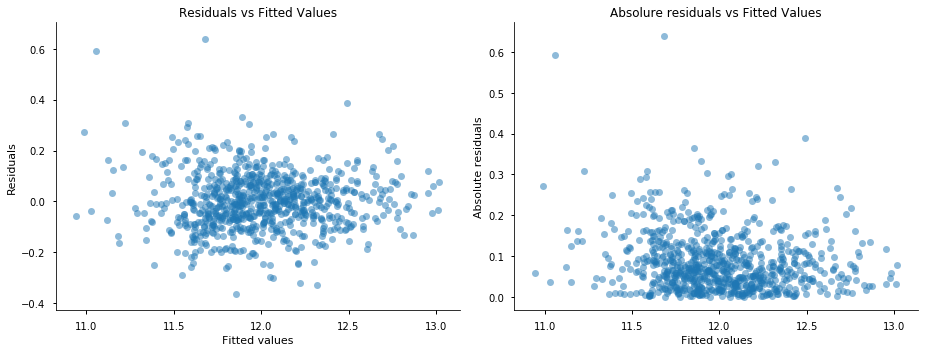

In [55]:
#Residual plots of OLS.

ols.fit(data_s[predictors1], data_s['LogSalePrice'])
y_fit = ols.predict(data_s[predictors1])
y_actual = data_s['LogSalePrice']
residuals = y_fit-y_actual
abs_residuals = abs(residuals)

fig, ax= plt.subplots(1,2, figsize=(13,5))
sns.regplot(y_fit, residuals, fit_reg=False, ax=ax[0], scatter_kws={'alpha':0.5})
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Residuals')
ax[0].set(title='Residuals vs Fitted Values')
sns.regplot(y_fit, abs_residuals, fit_reg=False, ax=ax[1], scatter_kws={'alpha':0.5, 'color': sns.color_palette()[0]})
ax[1].set_xlabel('Fitted values')
ax[1].set_ylabel('Absolute residuals')
ax[1].set(title='Absolure residuals vs Fitted Values')
sns.despine()
plt.tight_layout()
plt.show()
fig.savefig('residuals_OLS.png')

In [ ]:
#Heatmap to check for perfect multicollinearity. ALready done in previous steps when creating heatmaps, but checking again. 

data_s[predictors1].corr().round(4)
fig, ax = plt.subplots(figsize = (10,10))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(data_s[predictors1].corr(), ax=ax, cmap=cmap,center=0)
ax.set(title='Correlation heatmap for predictors used in OLS')
#fig.savefig('correlation_OLS.png')

## Lasso, Ridge, and Elastic Net

#### LASSO (Submission 21, MAE = 13277.61)

In [57]:
#Linear Regression fit to compare to Lasso, Ridge, and ENet coefficents.

from sklearn.linear_model import LinearRegression
ols2 = LinearRegression()
ols2.fit(data_s[predictors2],data_s['LogSalePrice'])

#Lasso CV to select shrinkage ad fit Lasso on 51 variables.

from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5)
lasso.fit(data_s[predictors2], np.ravel(data_s['LogSalePrice']))

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [58]:
#Ratio of Lasso coefficients to OLS coefficients

round(np.linalg.norm(lasso.coef_, ord=1)/np.linalg.norm(np.ravel(ols2.coef_), ord=1),10)

0.58027191990000004

In [59]:
#Display Lasso coefficients.

pd.set_option('display.max_columns',51)
pd.DataFrame(lasso.coef_.round(5), index = predictors2).T

,OverallQual,BsmtSF_Qual,GrLivArea,GarageCars,GarageArea_Cars,GarageArea,ExterQual,BsmtQual,TotalBsmtSF,KitchenQual,AgeHouse,FullBath,FireplaceQu,Foundation_PConc,Neighborhood_St_No_NHt,HeatingQC,GarageType_Attchd,GarageFinish_Unf,BsmtFinType1_GLQ,BsmtFinSF1,AgeGarage,Neighborhood_Old_Ed_SW_Brk,MSSubClass_60,MasVnrArea,CentralAir_Y,PavedDrive_Y,Exterior1st_VinylSd,Exterior2nd_VinylSd,GarageQual,BsmtExposure,MSZoning_RM,WoodDeckSF,GarageFinish_Fin,LotShape_Reg,MasVnrType_None,HalfBath,MSSubClass_30,OpenPorchSF,Electrical_SBrkr,GarageFinish_RFn,LotArea,Foundation_BrkTil,Neighborhood_Gr_CC_So_Ti,Neighborhood_Sa_NA_Bl_NP,BsmtFinType1_NA,BsmtFinType2_NA,MasVnrType_Stone,Neighborhood_Gi_NWA_Cr_Co,Neighborhood_BrD_IDO,BedroomAbvGr,Fence_NA
0,0.16589,0.0651,0.23089,0.0458,0.0,0.03525,0.0,0.0,0.00986,0.03558,-0.04396,-0.0,0.03059,0.0,0.01431,0.03064,0.00717,-0.0,0.0,0.06962,0.0,-0.0074,0.0,0.0,0.02214,0.01398,0.0,0.0025,0.00217,0.02277,-0.02254,0.0,0.00299,-0.00938,-0.0,0.0,-0.00773,0.00069,0.00224,0.0,0.03032,-0.0,0.01596,-0.00247,-0.00468,-0.0,0.0,0.0106,-0.00553,-0.0,-0.0


In [60]:
#Calculate Lasso MAE CV Score on LogSalePrice

scores_lasso = cross_val_score(lasso, data_s[predictors2], np.ravel(data_s['LogSalePrice']), 
                               cv=10, scoring = 'neg_mean_absolute_error')
cv_mae_lasso = np.mean(-1*scores_lasso)
cv_mae_lasso

0.082684526458542212

In [ ]:
#Residual plots of Lasso

lasso.fit(data_s[predictors2], data_s['LogSalePrice'])
y_fit = lasso.predict(data_s[predictors2])
y_actual = data_s['LogSalePrice']
residuals = y_fit - y_actual
abs_residuals = abs(residuals)

fig, ax= plt.subplots(1,2, figsize=(13,5))
sns.regplot(y_fit, residuals, fit_reg=False, ax=ax[0], scatter_kws={'alpha':0.5})
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Residuals')
ax[0].set(title='Residuals vs Fitted Values')
sns.regplot(y_fit, abs_residuals, fit_reg=False, ax=ax[1], scatter_kws={'alpha':0.5, 'color': sns.color_palette()[0]})
ax[1].set_xlabel('Fitted values')
ax[1].set_ylabel('Absolute residuals')
ax[1].set(title='Absolute residuals vs Fitted Values')
sns.despine()
plt.tight_layout()
plt.show()
fig.savefig('residuals_lasso.png')

#### Fwd + Ridge (Submission 18, MAE = 13225.03)

In [62]:
#Define function and class for forward selection algorithm taken from Marcel's QBUS2820 file and edited for MAE.

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

def forwardselection(X, y):
    """Forward variable selection based on the Scikit learn API
    
    
    Output:
    ----------------------------------------------------------------------------------
    Scikit learn OLS regression object for the best model
    """

    # Functions
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score

    # Initialisation
    base = []
    p = X.shape[1]
    candidates = list(np.arange(p))

    # Forward recursion
    i=1
    bestcvscore=-np.inf    
    while i<=p:
        bestscore = 0
        for variable in candidates:
            ols = LinearRegression()
            ols.fit(X.iloc[:, base + [variable]], y)
            score = ols.score(X.iloc[:, base + [variable]], y)
            if score > bestscore:
                bestscore = score 
                best = ols
                newvariable=variable
        base.append(newvariable)
        candidates.remove(newvariable)
        
        cvscore = cross_val_score(best, X.iloc[:, base], y, scoring='neg_mean_absolute_error').mean() 
        
        if cvscore > bestcvscore:
            bestcvscore=cvscore
            bestcv = best
            subset = base[:]
        i+=1
    
    #Finalise
    return bestcv, subset

class forward:
    def __init__(self):
        pass

    def fit(self, X, y):
        self.ols, self.subset = forwardselection(X, y)

    def predict(self, X):
        return self.ols.predict(X.iloc[:, self.subset])

    def cv_score(self, X, y, cv=10):
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(self.ols, X.iloc[:, self.subset], np.ravel(y), cv=cv, scoring='neg_mean_absolute_error')
        return -1*np.mean(scores)

In [63]:
#Fit forward selection on 51 predicotrs and print index of chosen predictors.

fwd = forward()
fwd.fit(data_s[predictors2], data_s['LogSalePrice'])
forwardselection(data_s[predictors2],data_s['LogSalePrice'])

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 [0,
  2,
  1,
  19,
  10,
  3,
  30,
  24,
  40,
  15,
  12,
  29,
  25,
  9,
  11,
  42,
  47,
  14,
  36,
  20,
  5])

In [64]:
#Copy and paste index from above output and run through loop to extract predictor names.
#Name chosen list of predictors to be predictors_fw

fwd_predictors_index = [0,2,1,19,10,3,30,24,40,15,12,29,25,9,11,42,47,14,36,20,5]
 
predictors_fw = []
for i in fwd_predictors_index:
    predictors_fw.append(predictors2[i])
print(predictors_fw)

['OverallQual', 'GrLivArea', 'BsmtSF_Qual', 'BsmtFinSF1', 'AgeHouse', 'GarageCars', 'MSZoning_RM', 'CentralAir_Y', 'LotArea', 'HeatingQC', 'FireplaceQu', 'BsmtExposure', 'PavedDrive_Y', 'KitchenQual', 'FullBath', 'Neighborhood_Gr_CC_So_Ti', 'Neighborhood_Gi_NWA_Cr_Co', 'Neighborhood_St_No_NHt', 'MSSubClass_30', 'AgeGarage', 'GarageArea']


In [65]:
#Ridge CV to select shrinkage.

from sklearn.linear_model import RidgeCV
alphas = np.exp(np.linspace(-10,20,500)) 
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(data_s[predictors_fw], np.ravel(data_s['LogSalePrice']))

RidgeCV(alphas=array([  4.53999e-05,   4.82131e-05, ...,   4.56856e+08,   4.85165e+08]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [66]:
#Ratio of Ridge to OLS coefficients of forward selected predictors.

from sklearn.linear_model import LinearRegression
ols3 = LinearRegression()
ols3.fit(data_s[predictors_fw],data_s['LogSalePrice'])
print(round(np.linalg.norm(ridge.coef_)/np.linalg.norm(np.ravel(ols3.coef_)), 3))

0.917


In [67]:
#Fit Ridge on forward selected predictors.

from sklearn.linear_model import Ridge
ridge_fw = Ridge(alpha=ridge.alpha_)
ridge_fw.fit(data_s[predictors_fw], np.ravel(data_s['LogSalePrice']))

Ridge(alpha=13.808032678892813, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [68]:
#Display ridge coefficients

pd.set_option('display.max_columns',50)
pd.DataFrame(ridge_fw.coef_.round(5), index = predictors_fw).T

,OverallQual,GrLivArea,BsmtSF_Qual,BsmtFinSF1,AgeHouse,GarageCars,MSZoning_RM,CentralAir_Y,LotArea,HeatingQC,FireplaceQu,BsmtExposure,PavedDrive_Y,KitchenQual,FullBath,Neighborhood_Gr_CC_So_Ti,Neighborhood_Gi_NWA_Cr_Co,Neighborhood_St_No_NHt,MSSubClass_30,AgeGarage,GarageArea
0,0.15172,0.21544,0.08486,0.07689,-0.06411,0.05391,-0.0276,0.0227,0.04431,0.04468,0.04548,0.03468,0.01547,0.04334,-0.0114,0.02366,0.02309,0.02158,-0.01627,0.02636,0.04658


In [69]:
#Calculate Ridge MAE CV on LogSalePrice

scores_ridge = cross_val_score(ridge_fw, data_s[predictors_fw], np.ravel(data_s['LogSalePrice']), 
                               cv=10, scoring = 'neg_mean_absolute_error')
cv_mae_ridge = np.mean(-1*scores_ridge)
cv_mae_ridge

0.080683240855718943

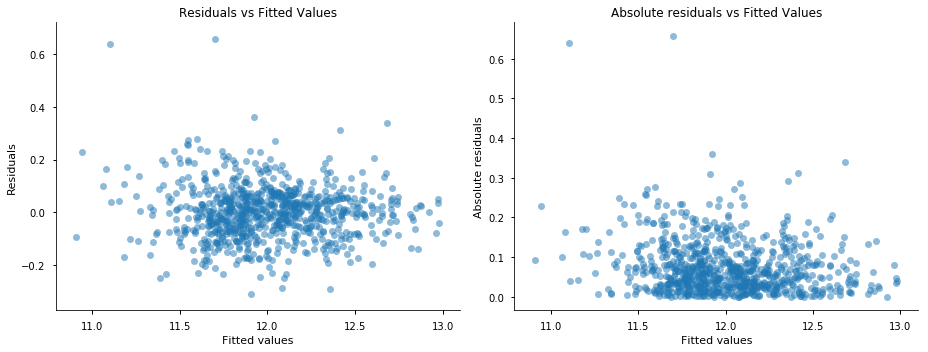

In [70]:
#Residual plot of Ridge with forward selection

ridge_fw.fit(data_s[predictors2], data_s['LogSalePrice'])
y_fit = ridge_fw.predict(data_s[predictors2])
y_actual = data_s['LogSalePrice']
residuals = y_fit-y_actual
abs_residuals = abs(residuals)

fig, ax= plt.subplots(1,2, figsize=(13,5))
sns.regplot(y_fit, residuals, fit_reg=False, ax=ax[0], scatter_kws={'alpha':0.5})
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Residuals')
ax[0].set(title='Residuals vs Fitted Values')
sns.regplot(y_fit, abs_residuals, fit_reg=False, ax=ax[1], scatter_kws={'alpha':0.5, 'color': sns.color_palette()[0]})
ax[1].set_xlabel('Fitted values')
ax[1].set_ylabel('Absolute residuals')
ax[1].set(title='Absolute residuals vs Fitted Values')
sns.despine()
plt.tight_layout()
plt.show()
#fig.savefig('residuals_ridge_with_fwd.png')

In [ ]:
#Correlation heatmap on forward selected predictors to see relationships and check for perfect multicollinearity.

data_num[predictors_fw].corr().round(4)
fig, ax = plt.subplots(figsize = (14,14))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(data_num[predictors_fw].corr(), ax=ax, cmap=cmap)
ax.set(title='Correlation heatmap for variables used in ridge regression (selected by forward selection)')
#fig.savefig('Correlation heatmap ridge.png')

#### ElasticNet (Submission 19, MAE = 13280.37)

In [72]:
#Select ENet shrinkage

from sklearn.linear_model import ElasticNetCV
enet = ElasticNetCV(l1_ratio=[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99], cv=5)
enet.fit(data_s[predictors2],np.ravel(data_s['LogSalePrice']))

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [73]:
#Fit ENet model on 51 predictors

from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=enet.alpha_, l1_ratio=enet.l1_ratio_)
enet.fit(data_s[predictors2],np.ravel(data_s['LogSalePrice']))

ElasticNet(alpha=0.011135554110250953, copy_X=True, fit_intercept=True,
      l1_ratio=0.40000000000000002, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [74]:
#Ratio of ENet coefficients to OLS coefficients.

from sklearn.linear_model import LinearRegression
ols4 = LinearRegression()
ols4.fit(data_s[predictors2],data_s['LogSalePrice'])
print(round(np.linalg.norm(enet.coef_)/np.linalg.norm(np.ravel(ols4.coef_)), 3))

0.786


In [75]:
#Display ENet coefficients.

pd.set_option('display.max_columns',51)
pd.DataFrame(enet.coef_.round(5), index = predictors2).T

,OverallQual,BsmtSF_Qual,GrLivArea,GarageCars,GarageArea_Cars,GarageArea,ExterQual,BsmtQual,TotalBsmtSF,KitchenQual,AgeHouse,FullBath,FireplaceQu,Foundation_PConc,Neighborhood_St_No_NHt,HeatingQC,GarageType_Attchd,GarageFinish_Unf,BsmtFinType1_GLQ,BsmtFinSF1,AgeGarage,Neighborhood_Old_Ed_SW_Brk,MSSubClass_60,MasVnrArea,CentralAir_Y,PavedDrive_Y,Exterior1st_VinylSd,Exterior2nd_VinylSd,GarageQual,BsmtExposure,MSZoning_RM,WoodDeckSF,GarageFinish_Fin,LotShape_Reg,MasVnrType_None,HalfBath,MSSubClass_30,OpenPorchSF,Electrical_SBrkr,GarageFinish_RFn,LotArea,Foundation_BrkTil,Neighborhood_Gr_CC_So_Ti,Neighborhood_Sa_NA_Bl_NP,BsmtFinType1_NA,BsmtFinType2_NA,MasVnrType_Stone,Neighborhood_Gi_NWA_Cr_Co,Neighborhood_BrD_IDO,BedroomAbvGr,Fence_NA
0,0.15801,0.05271,0.22135,0.04621,0.0,0.03732,0.0,0.0,0.02346,0.03806,-0.04494,-0.0,0.03557,0.0,0.01651,0.03242,0.00656,-0.0,0.0,0.0679,0.0,-0.00844,0.0,0.0,0.02177,0.0137,0.0,0.00251,0.00437,0.02327,-0.02209,0.0,0.00401,-0.00949,-0.0,0.0,-0.00952,0.00361,0.00214,0.0,0.03116,-0.0,0.01675,-0.00433,-0.00373,-0.00095,0.0,0.01155,-0.0061,-0.0,-0.0


In [76]:
#List of ENet predictors.

enet_pred = ['OverallQual', 'BsmtSF_Qual', 'GrLivArea', 'GarageCars', 'GarageArea', 
           'BsmtQual', 'TotalBsmtSF', 'KitchenQual', 'AgeHouse', 'FireplaceQu', 
          'Neighborhood_St_No_NHt','HeatingQC','GarageType_Attchd', 'BsmtFinSF1', 
          'Neighborhood_Old_Ed_SW_Brk', 'CentralAir_Y', 'PavedDrive_Y', 'Exterior2nd_VinylSd',
          'GarageQual', 'BsmtExposure', 'MSZoning_RM', 'GarageFinish_Fin', 'LotShape_Reg',
          'MSSubClass_30','Electrical_SBrkr','LotArea', 'Neighborhood_Gr_CC_So_Ti', 'Neighborhood_Sa_NA_Bl_NP',
          'Neighborhood_Gi_NWA_Cr_Co', 'Neighborhood_BrD_IDO']

In [77]:
#To calculate ENet MAE CV on LogSalePrice

scores_enet = cross_val_score(enet, data_s[predictors2], np.ravel(data_s['LogSalePrice']), 
                               cv=10, scoring = 'neg_mean_absolute_error')
cv_mae_enet = np.mean(-1*scores_enet)
cv_mae_enet

0.082122139100778757

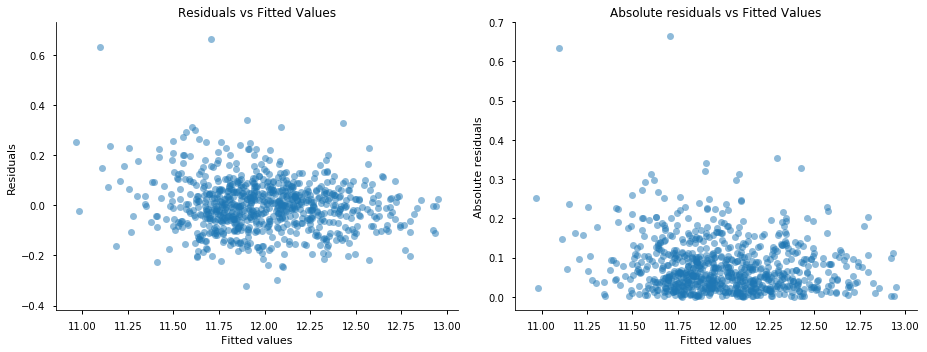

In [78]:
#Residual plots of Elastic net

enet.fit(data_s[predictors2], data_s['LogSalePrice'])
y_fit = enet.predict(data_s[predictors2])
y_actual = data_s['LogSalePrice']
residuals = y_fit-y_actual
abs_residuals = abs(residuals)

fig, ax= plt.subplots(1,2, figsize=(13,5))
sns.regplot(y_fit, residuals, fit_reg=False, ax=ax[0], scatter_kws={'alpha':0.5})
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Residuals')
ax[0].set(title='Residuals vs Fitted Values')
sns.regplot(y_fit, abs_residuals, fit_reg=False, ax=ax[1], scatter_kws={'alpha':0.5, 'color': sns.color_palette()[0]})
ax[1].set_xlabel('Fitted values')
ax[1].set_ylabel('Absolute residuals')
ax[1].set(title='Absolute residuals vs Fitted Values')
sns.despine()
plt.tight_layout()
plt.show()
#fig.savefig('residuals_enet.png')

In [ ]:
#Heatmap of ENet predictors.

data_num[enet_pred].corr().round(4)
fig, ax = plt.subplots(figsize = (14,14))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(data_num[enet_pred].corr(), ax=ax, cmap=cmap)
ax.set(title='Correlation heatmap for variables used in elastic net')
#fig.savefig('Correlation heatmap enet.png')

## PCR with Forward Selection (Submission 22, MAE = 20918.68)

In [80]:
#PCR algorithms taken from Marcel's QBUS2820 file and edited for MAE.

class PCR:
    def __init__(self, M=1):
        self.M=M

    def fit(self, X, y):
        from sklearn.decomposition import PCA
        from sklearn.linear_model import LinearRegression
        
        self.pca=PCA(n_components=self.M)
        Z= self.pca.fit_transform(X)
        self.pcr = LinearRegression().fit(Z, y)

    def predict(self, X):
        return self.pcr.predict(self.pca.transform(X))

    def cv_score(self, X, y, cv=10):
        from sklearn.model_selection import cross_val_score
        Z=self.pca.transform(X)
        scores = cross_val_score(self.pcr, Z, np.ravel(y), cv=cv, scoring='neg_mean_absolute_error').mean() 
        return -1*np.mean(scores)


def pcrCV(X, y):
    # Approximate cross-validation
    from sklearn.model_selection import cross_val_score
    
    p=X.shape[1]
    bestscore= -np.inf
    cv_scores = []
    for m in range(1,p+1):
        model = PCR(M=m)
        model.fit(X, y)
        Z=model.pca.transform(X)
        score = cross_val_score(model.pcr, Z, y, cv=10, scoring='neg_mean_absolute_error').mean() 
        cv_scores.append(score)
        if score > bestscore:
            bestscore=score
            best=model

    best.cv_scores = pd.Series(cv_scores, index = np.arange(1,p+1))
    return best

In [81]:
#Fit PCR model.
pcr = pcrCV(data_s[predictors_fw],data_s['LogSalePrice'])

In [82]:
#To calculate PCR MAE CV on LogSalePrice.

cv_score_pcr = pcr.cv_score(data_s[predictors_fw], np.ravel(data_s['LogSalePrice']), cv=10)
cv_score_pcr

0.080880017256897085

In [ ]:
#Residual plot of PCR

pcr.fit(data_s[predictors2], data_s['LogSalePrice'])
y_fit = pcr.predict(data_s[predictors2])
y_actual = data_s['LogSalePrice']
residuals = y_fit-y_actual
abs_residuals = abs(residuals)

fig, ax= plt.subplots(1,2, figsize=(13,5))
sns.regplot(y_fit, residuals, fit_reg=False, ax=ax[0], scatter_kws={'alpha':0.5})
ax[0].set_xlabel('Fitted values')
ax[0].set_ylabel('Residuals')
ax[0].set(title='Residuals vs Fitted Values')
sns.regplot(y_fit, abs_residuals, fit_reg=False, ax=ax[1], scatter_kws={'alpha':0.5, 'color': sns.color_palette()[0]})
ax[1].set_xlabel('Fitted values')
ax[1].set_ylabel('Absolute residuals')
ax[1].set(title='Absolute residuals vs Fitted Values')
sns.despine()
plt.tight_layout()
plt.show()
#fig.savefig('residuals_pcr.png')

## KNN (Submission 23, MAE = 52483.60)

In [84]:
#Define KNN algorithm and combine with forward selection.

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

def knn_test(X, y):
    
    neighbours=np.arange(1, 40)
    best_score = -np.inf
    
    for k in neighbours: 
        knn = KNeighborsRegressor(n_neighbors = k, metric='mahalanobis', metric_params={'V': X.cov()}) 
        scores = cross_val_score(knn, X, y, cv=10, scoring = 'neg_mean_absolute_error')
        cv_score = np.mean(scores)
        if cv_score >= best_score:
            best_score = cv_score
            best_knn = knn
    
    knn = best_knn
    knn.fit(X, y)
    #predictions = knn.predict(test[predictors])
    #test_rmse = np.sqrt(mean_squared_error(test[response], predictions))
    #cv_rmse= np.sqrt(-best_score)
    cv_mae = -best_score
    print('Chosen K: {}'.format(knn.n_neighbors))
    #return test_rmse, cv_rmse 
    return cv_mae, knn

def select_knn(X, y):
    """Forward variable selection based on the Scikit learn API
    
    
    Output:
    ----------------------------------------------------------------------------------
    Scikit learn knn regression object for the best model
    """

    # Functions
    from sklearn.model_selection import cross_val_score

    # Initialisation
    base = []
    p = X.shape[1]
    candidates = list(np.arange(p))

    # Forward recursion
    i=1
    bestcvscore=-np.inf    
    while i<=p:
        bestscore = 0
        for variable in candidates:
            score,knn = knn_test(X.iloc[:, base + [variable]], y)
            #knn.fit(X.iloc[:, base + [variable]], y)
            #score = knn.score(X.iloc[:, base + [variable]], y)
            if score > bestscore:
                bestscore = score 
                best = knn
                newvariable=variable
        base.append(newvariable)
        candidates.remove(newvariable)
        
        cvscore = cross_val_score(best, X.iloc[:, base], y, scoring='neg_mean_absolute_error').mean() 
        
        if cvscore > bestcvscore:
            bestcvscore=cvscore
            bestcv = best
            subset = base[:]
        i+=1
    bestcv_mae = -bestcvscore
    #Finalise
    return bestcv, bestcv_mae

In [85]:
#Show correlations to have some initial KNN predictors.

pd.set_option('display.max_rows',300)
abs_correl = abs(data_num.corr().round(3)['LogSalePrice'])
abs_correl_sort = abs_correl.sort_values(ascending=False)
abs_correl_sort.head(20)

LogSalePrice        1.000
SalePrice           0.965
OverallQual         0.811
BsmtSF_Qual         0.728
GrLivArea           0.727
GarageCars          0.671
GarageArea_Cars     0.669
GarageArea_Qual     0.669
GarageArea          0.662
ExterQual           0.636
BsmtQual            0.616
TotalBsmtSF         0.616
KitchenQual         0.616
1stFlrSF            0.596
AgeHouse            0.546
FullBath            0.543
FireplaceQu         0.533
Foundation_PConc    0.530
Fireplaces          0.492
TotRmsAbvGrd        0.482
Name: LogSalePrice, dtype: float64

In [86]:
abs_correl_sort.head(20).index

Index(['LogSalePrice', 'SalePrice', 'OverallQual', 'BsmtSF_Qual', 'GrLivArea',
       'GarageCars', 'GarageArea_Cars', 'GarageArea_Qual', 'GarageArea',
       'ExterQual', 'BsmtQual', 'TotalBsmtSF', 'KitchenQual', '1stFlrSF',
       'AgeHouse', 'FullBath', 'FireplaceQu', 'Foundation_PConc', 'Fireplaces',
       'TotRmsAbvGrd'],
      dtype='object')

In [87]:
#Create list of KNN predictors.
#Use the top correlated prodictors
#Keep some intersction terms and processsed terms rather than the original terms, because they contains more information.

predictors_knn = ['OverallQual', 'BsmtSF_Qual','GrLivArea', 'GarageArea_Cars', 'ExterQual', 'AgeHouse']

In [ ]:
#Correlation heatmap.

data_num[predictors_knn].corr().round(4)
fig, ax = plt.subplots(figsize = (10,10))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(data_num[predictors_knn].corr(), ax=ax, cmap=cmap)
ax.set(title='Correlation heatmap for variables used in KNN')
#fig.savefig('correlation_knn.png')

In [89]:
#Create copy to standardize
data_k = data_num.copy()

In [90]:
#Standardize data.

sigma=data_k[predictors_knn].std()
data_k[predictors_knn]=data_k[predictors_knn]/(2*sigma) 

In [91]:
#Run KNN forward selection algorithm and fit model.

knn,bestcv_mae = select_knn(data_k[predictors_knn],data_k['LogSalePrice'])
print(knn)
print(bestcv_mae)

Chosen K: 37
Chosen K: 39
Chosen K: 37
Chosen K: 35
Chosen K: 25
Chosen K: 39
Chosen K: 26
Chosen K: 16
Chosen K: 18
Chosen K: 20
Chosen K: 26
Chosen K: 18
Chosen K: 19
Chosen K: 11
Chosen K: 16
Chosen K: 9
Chosen K: 4
Chosen K: 7
Chosen K: 15
Chosen K: 10
Chosen K: 4
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='mahalanobis',
          metric_params={'V':                  AgeHouse  ExterQual  BsmtSF_Qual  GarageArea_Cars  \
AgeHouse         0.250000  -0.135464    -0.098482        -0.092718
ExterQual       -0.135464   0.250000     0.139032         0.122051
BsmtSF_Qual     -0.098482   0.139032     0.250000         0.138337
...76   0.123440
OverallQual         0.250000   0.136405
GrLivArea           0.136405   0.250000  },
          n_jobs=1, n_neighbors=4, p=2, weights='uniform')
0.127881973958


## To Make Predictions

In [92]:
#Import validation set

data_v = pd.read_csv('test.csv')
data_v.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemod/Add,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,...,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType
0,1,30,RM,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,4,1910,2006,Hip,CompShg,MetalSd,Stucco,...,4,Maj2,0,NaN,Detchd,1956.0,Unf,1.0,280.0,TA,TA,Y,0,30,226,0,0,0,NaN,NaN,NaN,0,6,2009,WD
1,2,190,RL,90.0,15750,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,2fmCon,1Story,5,5,1953,1953,Hip,CompShg,MetalSd,MetalSd,...,5,Typ,2,Gd,Attchd,1953.0,Unf,1.0,375.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD
2,3,50,RL,65.0,6435,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,RRAn,Norm,1Fam,1.5Fin,6,5,1939,1950,Gable,CompShg,MetalSd,MetalSd,...,6,Typ,1,Gd,Detchd,1939.0,Unf,1.0,312.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2006,WD
3,4,60,RL,80.0,10400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,7,6,1980,1988,Gable,CompShg,HdBoard,HdBoard,...,7,Min1,1,TA,Attchd,1980.0,Unf,2.0,489.0,TA,TA,Y,28,73,0,0,0,0,NaN,NaN,NaN,0,3,2008,WD
4,5,20,RL,70.0,13300,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1956,2001,Hip,CompShg,Wd Sdng,VinylSd,...,6,Min1,0,NaN,Attchd,2001.0,Unf,2.0,896.0,TA,TA,Y,75,0,0,323,0,0,NaN,NaN,Shed,400,6,2006,WD


In [93]:
#Do all the same data manipulation/processing changes as with the train data!!

#Convert to string type

data_v['MSSubClass'] = data_v['MSSubClass'].astype(str)
data_v['MoSold'] = data_v['MoSold'].astype(str)

#Fill object type blanks with NA one by one for record purposes

data_v['LotFrontage'] = data_v['LotFrontage'].fillna(0)
data_v['Alley'] = data_v['Alley'].fillna('NA')
data_v['BsmtQual'] = data_v['BsmtQual'].fillna('NA')
data_v['BsmtCond'] = data_v['BsmtCond'].fillna('NA')
data_v['BsmtExposure'] = data_v['BsmtExposure'].fillna('NA')
data_v['BsmtFinType1'] = data_v['BsmtFinType1'].fillna('NA')
data_v['BsmtFinType2'] = data_v['BsmtFinType2'].fillna('NA')
data_v['FireplaceQu'] = data_v['FireplaceQu'].fillna('NA')
data_v['GarageType'] = data_v['GarageType'].fillna('NA')
data_v['GarageFinish'] = data_v['GarageFinish'].fillna('NA')
data_v['GarageQual'] = data_v['GarageQual'].fillna('NA')
data_v['GarageCond'] = data_v['GarageCond'].fillna('NA')
data_v['PoolQC'] = data_v['PoolQC'].fillna('NA')
data_v['Fence'] = data_v['Fence'].fillna('NA')
data_v['MiscFeature'] = data_v['MiscFeature'].fillna('NA')
data_v['MasVnrArea'] = data_v['MasVnrArea'].fillna(0)
data_v['MasVnrType'] = data_v['MasVnrType'].fillna('None')
data_v['BsmtFullBath'] = data_v['BsmtFullBath'].fillna(0)

#Create age house and age garage to use in analysis

data_v['AgeHouse'] = (data_v['YrSold'] - data_v['YearRemod/Add']).astype(float)
data_v['AgeGarage'] = (data_v['YrSold'] - data_v['GarageYrBlt']).astype(float)

#Delete year built, remodeled, and garage year built and fill blank AgeGarage with 0

del data_v['YearBuilt']
del data_v['YearRemod/Add']
del data_v['GarageYrBlt']
data_v['AgeGarage'] = data_v['AgeGarage'].fillna(0)

In [94]:
#Combine Neighborhood variables

neighbor_combined = {'MeadowV':'MeadowV',
                     'BrDale': 'BrD_IDO',
                     'IDOTRR': 'BrD_IDO',
                     'OldTown':'Old_Ed_SW_Brk',
                     'Edwards':'Old_Ed_SW_Brk',
                     'SWISU':'Old_Ed_SW_Brk',
                     'BrkSide':'Old_Ed_SW_Brk',
                     'Sawyer':'Sa_NA_Bl_NP',
                     'NAmes':'Sa_NA_Bl_NP',
                     'Blueste':'Sa_NA_Bl_NP',
                     'NPkVill':'Sa_NA_Bl_NP',
                     'Mitchel':'Mi_SaW,Bng',
                     'SawyerW':'Mi_SaW,Bng',
                     'Blmngtn':'Mi_SaW,Bng',
                     'Gilbert':'Gi_NWA_Cr_Co',
                     'NWAmes':'Gi_NWA_Cr_Co',
                     'Crawfor':'Gi_NWA_Cr_Co',
                     'CollgCr':'Gi_NWA_Cr_Co',
                     'Greens':'Gr_CC_So_Ti',
                     'ClearCr':'Gr_CC_So_Ti',
                     'Somerst':'Gr_CC_So_Ti',
                     'Timber':'Gr_CC_So_Ti',
                     'Veenker':'Veenker',
                     'StoneBr':'St_No_NHt',
                     'NoRidge':'St_No_NHt',
                     'NridgHt':'St_No_NHt'}
data_v['Neighborhood'] = data_v['Neighborhood'].map(neighbor_combined)

In [95]:
#Convert quality ordinals to numerical

exterqual_vals = {'Fa':1,'TA':2,'Gd':3,'Ex':4}
data_v['ExterQual'] = data_v['ExterQual'].map(exterqual_vals).astype(int)

bsmt_vals = {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
data_v['BsmtQual'] = data_v['BsmtQual'].map(bsmt_vals).astype(int)

bsmt_exp = {'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4}
data_v['BsmtExposure'] = data_v['BsmtExposure'].map(bsmt_exp).astype(int)

kitchen_vals = {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
data_v['KitchenQual'] = data_v['KitchenQual'].map(kitchen_vals).astype(int)

fireplace_qual = {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
data_v['FireplaceQu'] = data_v['FireplaceQu'].map(fireplace_qual).astype(int)

garage_vals= {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
data_v['GarageQual'] = data_v['GarageQual'].map(garage_vals).astype(int)

heating_vals = {'Fa':1,'TA':2,'Gd':3,'Ex':4}
data_v['HeatingQC'] = data_v['HeatingQC'].map(kitchen_vals).astype(int)

garage_cond = {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
data_v['GarageCond'] = data_v['GarageCond'].map(garage_cond).astype(int)

bsmt_cond = {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
data_v['BsmtCond'] = data_v['BsmtCond'].map(bsmt_cond).astype(int)

In [96]:
#Create different lists by data type.

columns_float_v = data_v.select_dtypes(['float64']).columns
columns_int_v = data_v.select_dtypes(['int64']).columns
columns_cat_v = data_v.select_dtypes(['object']).columns

In [97]:
#Create dummy variables as before.

columns_cat_v = list(columns_cat_v)
for column in columns_cat_v:
    data_v = pd.get_dummies(data_v, columns = [column])

In [98]:
#Create interactions as before.

data_v['BsmtSF_Qual'] = data_v['TotalBsmtSF']*data_v['BsmtQual']
data_v['GarageArea_Qual'] = data_v['GarageArea']*data_v['GarageQual']
data_v['GrLiv_Rooms'] = data_v['GrLivArea']*data_v['TotRmsAbvGrd']
data_v['GarageArea_Cars'] = data_v['GarageArea']*data_v['GarageCars']

In [99]:
#Standardize data for KNN.

data_knn = data_v.copy()
sigma=data_num[predictors_knn].std()
data_knn[predictors_knn]=data_knn[predictors_knn]/(2*sigma) 

In [100]:
#Standardize data for all other methods.

pred_float_v = data_v.select_dtypes(['float64']).columns
pred_int_v = data_v.select_dtypes(['int64']).columns
pred_dum_v = data_v.select_dtypes(['uint8']).columns

mu_float = np.mean(data_num[pred_float])
sigma_float = np.std(data_num[pred_float])

mu_int = np.mean(data_num[pred_int])
sigma_int = np.std(data_num[pred_int])

mu_dum = np.mean(data_num[pred_dum])
sigma_dum = np.std(data_num[pred_dum])

data_v[pred_float] = (data_v[pred_float]-mu_float)/(2*sigma_float)
data_v[pred_int] = (data_v[pred_int]-mu_int)/(2*sigma_int)
data_v[pred_dum] = (data_v[pred_dum])/(sigma_dum)

data_v.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,...,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_WD,BsmtSF_Qual,GarageArea_Qual,GrLiv_Rooms,GarageArea_Cars
0,1,60.0,-0.181676,-0.375442,4,-0.281024,-0.304895,-0.243117,3,-0.282776,-0.223621,465.0,310.0,0.009754,-0.580017,1022,0,0,-0.472128,1.0,0.0,-0.479465,-0.376436,-0.505721,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,-0.158828,840.0,4088,-0.486480
1,2,90.0,0.381354,-0.375442,5,-0.120486,-0.304895,-0.243117,3,0.198789,0.502414,0.0,324.0,0.193405,-0.580017,1336,0,0,-0.131225,1.0,0.0,-0.479465,-0.376436,-0.505721,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,-0.042517,1125.0,6680,-0.413720
2,3,65.0,-0.232053,0.009664,5,-0.281024,-0.304895,-0.243117,3,-0.282776,-0.525524,0.0,972.0,-0.054460,-0.053510,972,605,0,0.130423,0.0,0.0,-0.479465,-0.376436,0.107764,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.199496,936.0,9462,-0.461971
3,4,80.0,0.029049,0.394770,6,0.521666,-0.304895,0.337016,3,0.198789,-0.525524,0.0,738.0,-0.354980,-0.580017,1277,767,0,0.637434,0.0,0.0,0.457137,0.630340,0.107764,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.189736,1467.0,14308,0.048116
4,5,70.0,0.220018,-0.375442,5,-0.281024,-0.304895,-0.243117,3,-0.282776,0.078283,0.0,521.0,0.000764,-0.053510,1384,0,0,-0.079113,1.0,0.0,-0.479465,-0.376436,-0.505721,1,...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,-0.164522,2688.0,8304,0.671556


In [ ]:
#Predictions based on OLS model

y_predict_ols = pd.DataFrame(np.exp(ols.predict(data_v[predictors1])))
pd.set_option('display.max_rows', 1608)
y_predict_ols

In [ ]:
#Predictions based on Lasso model

y_predict_lasso = pd.DataFrame(np.exp(lasso.predict(data_v[predictors2])))
pd.set_option('display.max_rows', 1608)
y_predict_lasso

In [ ]:
#Predictions based on Forward + Ridge model

y_predict_ridge = pd.DataFrame(np.exp(ridge_fw.predict(data_v[predictors2])))
pd.set_option('display.max_rows', 1608)
y_predict_ridge

In [ ]:
#Predictions based on ENet model

y_predict_enet = pd.DataFrame(np.exp(enet.predict(data_v[predictors2])))
pd.set_option('display.max_rows', 1615)
y_predict_enet

In [ ]:
#Predictions based on Forward + PCR model

y_predict_pcr = pd.DataFrame(np.exp(pcr.predict(data_v[predictors2])))
pd.set_option('display.max_rows', 1608)
y_predict_pcr

In [ ]:
#Predictions based on KNN model

y_predict_knn = pd.DataFrame(np.exp(knn.predict(data_knn[predictors_knn])))
pd.set_option('display.max_rows', 1608)
y_predict_knn